# Regularization - How to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0  77906      0 --:--:-- --:--:-- --:--:-- 77906


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [11]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [15]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

In [16]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We have several means of regularization

 _We use a combination of them:_
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [17]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

dropout = 0.6
model = keras.Sequential()

model.add(Dense(500, name='hidden1', input_dim=2))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [18]:
# reducing batch size might increase overfitting, but might be necessary to reduce memory requirements 
BATCH_SIZE=1000

# reduce this based on what you see in the training history
EPOCHS = 10000

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/10000
720/720 [==============================] - 1s 861us/step - loss: 3.7268 - acc: 0.3333 - val_loss: 6.0506 - val_acc: 0.2722
Epoch 2/10000
720/720 [==============================] - 0s 23us/step - loss: 5.9532 - acc: 0.3278 - val_loss: 6.0041 - val_acc: 0.3278
Epoch 3/10000
720/720 [==============================] - 0s 11us/step - loss: 5.9839 - acc: 0.3361 - val_loss: 9.0720 - val_acc: 0.3389
Epoch 4/10000
720/720 [==============================] - 0s 11us/step - loss: 9.1423 - acc: 0.3306 - val_loss: 6.8635 - val_acc: 0.3389
Epoch 5/10000
720/720 [==============================] - 0s 11us/step - loss: 6.9247 - acc: 0.3306 - val_loss: 8.4470 - val_acc: 0.3278
Epoch 6/10000
720/720 [==============================] - 0s 28us/step - loss: 8.3346 - acc: 0.3361 - val_loss: 9.3734 - val_acc: 0.3278
Epoch 7/10000
720/720 [==============================] - 0s 11us/step - loss: 9.2170 - acc: 0.3361 - val_loss: 7.9006 - val_acc: 0.3278
E

Epoch 61/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7708 - acc: 0.4542 - val_loss: 5.8234 - val_acc: 0.4222
Epoch 62/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7799 - acc: 0.4375 - val_loss: 5.8163 - val_acc: 0.4333
Epoch 63/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7693 - acc: 0.4597 - val_loss: 5.8330 - val_acc: 0.4167
Epoch 64/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7781 - acc: 0.4514 - val_loss: 5.8194 - val_acc: 0.4222
Epoch 65/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7683 - acc: 0.4528 - val_loss: 5.8220 - val_acc: 0.4333
Epoch 66/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7767 - acc: 0.4431 - val_loss: 5.8172 - val_acc: 0.4278
Epoch 67/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7672 - acc: 0.4639 - val_loss: 5.8305 - val_acc: 0.4111
Epoch 68/10000
720/720 [====================

Epoch 121/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7604 - acc: 0.4528 - val_loss: 5.8141 - val_acc: 0.4278
Epoch 122/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7603 - acc: 0.4528 - val_loss: 5.8140 - val_acc: 0.4278
Epoch 123/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7602 - acc: 0.4556 - val_loss: 5.8146 - val_acc: 0.4278
Epoch 124/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7601 - acc: 0.4514 - val_loss: 5.8149 - val_acc: 0.4278
Epoch 125/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7600 - acc: 0.4528 - val_loss: 5.8147 - val_acc: 0.4222
Epoch 126/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7599 - acc: 0.4556 - val_loss: 5.8149 - val_acc: 0.4278
Epoch 127/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7598 - acc: 0.4514 - val_loss: 5.8145 - val_acc: 0.4278
Epoch 128/10000
720/720 [=============

Epoch 181/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7547 - acc: 0.4556 - val_loss: 5.8151 - val_acc: 0.4333
Epoch 182/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7546 - acc: 0.4556 - val_loss: 5.8155 - val_acc: 0.4333
Epoch 183/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7545 - acc: 0.4556 - val_loss: 5.8156 - val_acc: 0.4333
Epoch 184/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7544 - acc: 0.4556 - val_loss: 5.8152 - val_acc: 0.4333
Epoch 185/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7543 - acc: 0.4556 - val_loss: 5.8148 - val_acc: 0.4333
Epoch 186/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7543 - acc: 0.4542 - val_loss: 5.8150 - val_acc: 0.4333
Epoch 187/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7542 - acc: 0.4556 - val_loss: 5.8154 - val_acc: 0.4333
Epoch 188/10000
720/720 [=========

Epoch 241/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7603 - acc: 0.4694 - val_loss: 5.8267 - val_acc: 0.4222
Epoch 242/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7571 - acc: 0.4611 - val_loss: 5.8187 - val_acc: 0.4500
Epoch 243/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7543 - acc: 0.4778 - val_loss: 5.8222 - val_acc: 0.4278
Epoch 244/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7529 - acc: 0.4583 - val_loss: 5.8175 - val_acc: 0.4444
Epoch 245/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7518 - acc: 0.4722 - val_loss: 5.8206 - val_acc: 0.4278
Epoch 246/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7514 - acc: 0.4611 - val_loss: 5.8174 - val_acc: 0.4444
Epoch 247/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7514 - acc: 0.4750 - val_loss: 5.8214 - val_acc: 0.4278
Epoch 248/10000
720/720 [==========

Epoch 301/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7774 - acc: 0.4431 - val_loss: 5.8442 - val_acc: 0.4500
Epoch 302/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7816 - acc: 0.4639 - val_loss: 5.8563 - val_acc: 0.4222
Epoch 303/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7800 - acc: 0.4403 - val_loss: 5.8290 - val_acc: 0.4444
Epoch 304/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7654 - acc: 0.4611 - val_loss: 5.8259 - val_acc: 0.4278
Epoch 305/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7542 - acc: 0.4611 - val_loss: 5.8137 - val_acc: 0.4444
Epoch 306/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7473 - acc: 0.4736 - val_loss: 5.8135 - val_acc: 0.4444
Epoch 307/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7461 - acc: 0.4625 - val_loss: 5.8207 - val_acc: 0.4278
Epoch 308/10000
720/720 [=============

Epoch 361/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7461 - acc: 0.4625 - val_loss: 5.8224 - val_acc: 0.4611
Epoch 362/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7539 - acc: 0.4750 - val_loss: 5.8427 - val_acc: 0.4167
Epoch 363/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7635 - acc: 0.4597 - val_loss: 5.8332 - val_acc: 0.4500
Epoch 364/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7664 - acc: 0.4778 - val_loss: 5.8462 - val_acc: 0.4167
Epoch 365/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7674 - acc: 0.4528 - val_loss: 5.8256 - val_acc: 0.4444
Epoch 366/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7601 - acc: 0.4681 - val_loss: 5.8288 - val_acc: 0.4278
Epoch 367/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7539 - acc: 0.4583 - val_loss: 5.8142 - val_acc: 0.4611
Epoch 368/10000
720/720 [=========

Epoch 421/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7946 - acc: 0.4583 - val_loss: 5.8531 - val_acc: 0.4056
Epoch 422/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7762 - acc: 0.4417 - val_loss: 5.8163 - val_acc: 0.4611
Epoch 423/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7523 - acc: 0.4847 - val_loss: 5.8129 - val_acc: 0.4389
Epoch 424/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7407 - acc: 0.4681 - val_loss: 5.8136 - val_acc: 0.4500
Epoch 425/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7397 - acc: 0.4708 - val_loss: 5.8187 - val_acc: 0.4556
Epoch 426/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7468 - acc: 0.4917 - val_loss: 5.8406 - val_acc: 0.4167
Epoch 427/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7586 - acc: 0.4569 - val_loss: 5.8373 - val_acc: 0.4389
Epoch 428/10000
720/720 [=========

Epoch 481/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7680 - acc: 0.4444 - val_loss: 5.8402 - val_acc: 0.4444
Epoch 482/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7731 - acc: 0.4653 - val_loss: 5.8637 - val_acc: 0.4111
Epoch 483/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7811 - acc: 0.4389 - val_loss: 5.8357 - val_acc: 0.4444
Epoch 484/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7717 - acc: 0.4792 - val_loss: 5.8460 - val_acc: 0.4167
Epoch 485/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7665 - acc: 0.4528 - val_loss: 5.8196 - val_acc: 0.4667
Epoch 486/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7534 - acc: 0.4958 - val_loss: 5.8237 - val_acc: 0.4222
Epoch 487/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7452 - acc: 0.4611 - val_loss: 5.8121 - val_acc: 0.4611
Epoch 488/10000
720/720 [==========

Epoch 541/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7920 - acc: 0.4236 - val_loss: 5.8467 - val_acc: 0.4333
Epoch 542/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7807 - acc: 0.4653 - val_loss: 5.8587 - val_acc: 0.4167
Epoch 543/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7737 - acc: 0.4458 - val_loss: 5.8213 - val_acc: 0.4611
Epoch 544/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7532 - acc: 0.4889 - val_loss: 5.8193 - val_acc: 0.4278
Epoch 545/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7400 - acc: 0.4681 - val_loss: 5.8067 - val_acc: 0.4722
Epoch 546/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7325 - acc: 0.4917 - val_loss: 5.8071 - val_acc: 0.4722
Epoch 547/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7325 - acc: 0.4903 - val_loss: 5.8179 - val_acc: 0.4389
Epoch 548/10000
720/720 [==========

Epoch 601/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7365 - acc: 0.4736 - val_loss: 5.8038 - val_acc: 0.4611
Epoch 602/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7300 - acc: 0.4986 - val_loss: 5.8037 - val_acc: 0.4778
Epoch 603/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7279 - acc: 0.4931 - val_loss: 5.8073 - val_acc: 0.4778
Epoch 604/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7294 - acc: 0.4889 - val_loss: 5.8054 - val_acc: 0.4778
Epoch 605/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7334 - acc: 0.5069 - val_loss: 5.8212 - val_acc: 0.4333
Epoch 606/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7401 - acc: 0.4653 - val_loss: 5.8153 - val_acc: 0.4611
Epoch 607/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7471 - acc: 0.4889 - val_loss: 5.8432 - val_acc: 0.4222
Epoch 608/10000
720/720 [=========

Epoch 661/10000
720/720 [==============================] - 0s 39us/step - loss: 5.7489 - acc: 0.4917 - val_loss: 5.8429 - val_acc: 0.4222
Epoch 662/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7581 - acc: 0.4500 - val_loss: 5.8229 - val_acc: 0.4500
Epoch 663/10000
720/720 [==============================] - 0s 33us/step - loss: 5.7581 - acc: 0.4875 - val_loss: 5.8473 - val_acc: 0.4222
Epoch 664/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7614 - acc: 0.4514 - val_loss: 5.8213 - val_acc: 0.4500
Epoch 665/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7541 - acc: 0.4819 - val_loss: 5.8356 - val_acc: 0.4222
Epoch 666/10000
720/720 [==============================] - 0s 33us/step - loss: 5.7504 - acc: 0.4556 - val_loss: 5.8109 - val_acc: 0.4667
Epoch 667/10000
720/720 [==============================] - 0s 39us/step - loss: 5.7418 - acc: 0.4972 - val_loss: 5.8177 - val_acc: 0.4444
Epoch 668/10000
720/720 [=========

Epoch 721/10000
720/720 [==============================] - 0s 33us/step - loss: 5.7452 - acc: 0.4917 - val_loss: 5.8164 - val_acc: 0.4444
Epoch 722/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7300 - acc: 0.4861 - val_loss: 5.8051 - val_acc: 0.4833
Epoch 723/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7226 - acc: 0.5153 - val_loss: 5.8066 - val_acc: 0.4722
Epoch 724/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7246 - acc: 0.5125 - val_loss: 5.8235 - val_acc: 0.4556
Epoch 725/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7329 - acc: 0.4861 - val_loss: 5.8179 - val_acc: 0.4667
Epoch 726/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7419 - acc: 0.4903 - val_loss: 5.8439 - val_acc: 0.4333
Epoch 727/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7523 - acc: 0.4556 - val_loss: 5.8221 - val_acc: 0.4444
Epoch 728/10000
720/720 [=========

Epoch 781/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7530 - acc: 0.4861 - val_loss: 5.8349 - val_acc: 0.4278
Epoch 782/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7494 - acc: 0.4625 - val_loss: 5.8052 - val_acc: 0.4611
Epoch 783/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7381 - acc: 0.4875 - val_loss: 5.8140 - val_acc: 0.4556
Epoch 784/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7307 - acc: 0.4875 - val_loss: 5.7966 - val_acc: 0.4722
Epoch 785/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7238 - acc: 0.5000 - val_loss: 5.7999 - val_acc: 0.4889
Epoch 786/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7200 - acc: 0.5167 - val_loss: 5.7950 - val_acc: 0.4944
Epoch 787/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7183 - acc: 0.5125 - val_loss: 5.7936 - val_acc: 0.4889
Epoch 788/10000
720/720 [=========

Epoch 841/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7291 - acc: 0.4917 - val_loss: 5.7992 - val_acc: 0.4889
Epoch 842/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7187 - acc: 0.5139 - val_loss: 5.7969 - val_acc: 0.4944
Epoch 843/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7169 - acc: 0.5153 - val_loss: 5.7969 - val_acc: 0.4722
Epoch 844/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7224 - acc: 0.5014 - val_loss: 5.8202 - val_acc: 0.4611
Epoch 845/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7328 - acc: 0.4833 - val_loss: 5.8107 - val_acc: 0.4500
Epoch 846/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7419 - acc: 0.4819 - val_loss: 5.8441 - val_acc: 0.4333
Epoch 847/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7545 - acc: 0.4597 - val_loss: 5.8194 - val_acc: 0.4333
Epoch 848/10000
720/720 [=========

Epoch 901/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7347 - acc: 0.4861 - val_loss: 5.8023 - val_acc: 0.4667
Epoch 902/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7200 - acc: 0.5097 - val_loss: 5.7903 - val_acc: 0.4944
Epoch 903/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7135 - acc: 0.5153 - val_loss: 5.7909 - val_acc: 0.4722
Epoch 904/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7163 - acc: 0.5000 - val_loss: 5.8114 - val_acc: 0.4556
Epoch 905/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7253 - acc: 0.5028 - val_loss: 5.8035 - val_acc: 0.4611
Epoch 906/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7341 - acc: 0.4819 - val_loss: 5.8316 - val_acc: 0.4500
Epoch 907/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7421 - acc: 0.4736 - val_loss: 5.8041 - val_acc: 0.4611
Epoch 908/10000
720/720 [===========

Epoch 961/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7245 - acc: 0.4903 - val_loss: 5.8218 - val_acc: 0.4667
Epoch 962/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7306 - acc: 0.4917 - val_loss: 5.8052 - val_acc: 0.4611
Epoch 963/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7346 - acc: 0.4847 - val_loss: 5.8339 - val_acc: 0.4556
Epoch 964/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7416 - acc: 0.4736 - val_loss: 5.8101 - val_acc: 0.4556
Epoch 965/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7413 - acc: 0.4847 - val_loss: 5.8353 - val_acc: 0.4611
Epoch 966/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7427 - acc: 0.4736 - val_loss: 5.8058 - val_acc: 0.4611
Epoch 967/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7353 - acc: 0.4861 - val_loss: 5.8197 - val_acc: 0.4611
Epoch 968/10000
720/720 [=========

Epoch 1021/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7202 - acc: 0.4917 - val_loss: 5.8071 - val_acc: 0.4667
Epoch 1022/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7172 - acc: 0.5139 - val_loss: 5.7921 - val_acc: 0.4778
Epoch 1023/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7141 - acc: 0.5014 - val_loss: 5.7985 - val_acc: 0.4944
Epoch 1024/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7120 - acc: 0.5181 - val_loss: 5.7900 - val_acc: 0.4778
Epoch 1025/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7104 - acc: 0.5056 - val_loss: 5.7936 - val_acc: 0.4889
Epoch 1026/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7096 - acc: 0.5181 - val_loss: 5.7902 - val_acc: 0.4889
Epoch 1027/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7091 - acc: 0.5097 - val_loss: 5.7912 - val_acc: 0.4833
Epoch 1028/10000
720/720 [=

Epoch 1080/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7403 - acc: 0.4806 - val_loss: 5.7977 - val_acc: 0.4611
Epoch 1081/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7300 - acc: 0.4889 - val_loss: 5.8082 - val_acc: 0.4722
Epoch 1082/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7200 - acc: 0.5097 - val_loss: 5.7885 - val_acc: 0.4722
Epoch 1083/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7112 - acc: 0.5042 - val_loss: 5.7904 - val_acc: 0.4889
Epoch 1084/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7080 - acc: 0.5153 - val_loss: 5.7957 - val_acc: 0.4778
Epoch 1085/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7100 - acc: 0.5181 - val_loss: 5.7899 - val_acc: 0.4667
Epoch 1086/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7152 - acc: 0.4958 - val_loss: 5.8120 - val_acc: 0.4778
Epoch 1087/10000
720/720 [===

Epoch 1139/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7229 - acc: 0.5056 - val_loss: 5.7955 - val_acc: 0.4611
Epoch 1140/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7271 - acc: 0.4861 - val_loss: 5.8259 - val_acc: 0.4722
Epoch 1141/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7329 - acc: 0.4958 - val_loss: 5.8014 - val_acc: 0.4556
Epoch 1142/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7330 - acc: 0.4875 - val_loss: 5.8283 - val_acc: 0.4667
Epoch 1143/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7330 - acc: 0.4889 - val_loss: 5.7992 - val_acc: 0.4667
Epoch 1144/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7257 - acc: 0.4875 - val_loss: 5.8121 - val_acc: 0.4667
Epoch 1145/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7185 - acc: 0.5139 - val_loss: 5.7922 - val_acc: 0.4722
Epoch 1146/10000
720/720 [=

Epoch 1198/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7056 - acc: 0.5139 - val_loss: 5.7907 - val_acc: 0.4778
Epoch 1199/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7050 - acc: 0.5139 - val_loss: 5.7929 - val_acc: 0.4833
Epoch 1200/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7056 - acc: 0.5139 - val_loss: 5.7880 - val_acc: 0.4778
Epoch 1201/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7069 - acc: 0.5056 - val_loss: 5.7978 - val_acc: 0.4722
Epoch 1202/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7088 - acc: 0.5111 - val_loss: 5.7883 - val_acc: 0.4778
Epoch 1203/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7108 - acc: 0.5014 - val_loss: 5.8047 - val_acc: 0.4667
Epoch 1204/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7134 - acc: 0.5083 - val_loss: 5.7915 - val_acc: 0.4667
Epoch 1205/10000
720/720 [=

Epoch 1257/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7130 - acc: 0.4958 - val_loss: 5.7816 - val_acc: 0.4722
Epoch 1258/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7056 - acc: 0.5139 - val_loss: 5.7953 - val_acc: 0.4611
Epoch 1259/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7120 - acc: 0.5139 - val_loss: 5.7855 - val_acc: 0.4667
Epoch 1260/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7191 - acc: 0.4875 - val_loss: 5.8032 - val_acc: 0.4722
Epoch 1261/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7171 - acc: 0.5069 - val_loss: 5.7824 - val_acc: 0.4778
Epoch 1262/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7080 - acc: 0.5028 - val_loss: 5.7841 - val_acc: 0.4833
Epoch 1263/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7052 - acc: 0.5125 - val_loss: 5.7975 - val_acc: 0.4667
Epoch 1264/10000
720/720 [==

Epoch 1316/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7035 - acc: 0.5153 - val_loss: 5.7876 - val_acc: 0.4778
Epoch 1317/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7035 - acc: 0.5153 - val_loss: 5.7885 - val_acc: 0.4778
Epoch 1318/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7035 - acc: 0.5167 - val_loss: 5.7867 - val_acc: 0.4722
Epoch 1319/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7035 - acc: 0.5153 - val_loss: 5.7876 - val_acc: 0.4778
Epoch 1320/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7034 - acc: 0.5167 - val_loss: 5.7860 - val_acc: 0.4778
Epoch 1321/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7034 - acc: 0.5139 - val_loss: 5.7868 - val_acc: 0.4778
Epoch 1322/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7034 - acc: 0.5139 - val_loss: 5.7864 - val_acc: 0.4778
Epoch 1323/10000
720/720 [==

Epoch 1375/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7042 - acc: 0.5083 - val_loss: 5.7930 - val_acc: 0.4722
Epoch 1376/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7049 - acc: 0.5069 - val_loss: 5.7847 - val_acc: 0.4778
Epoch 1377/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7057 - acc: 0.5056 - val_loss: 5.7960 - val_acc: 0.4667
Epoch 1378/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7070 - acc: 0.5111 - val_loss: 5.7854 - val_acc: 0.4667
Epoch 1379/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7083 - acc: 0.4972 - val_loss: 5.8018 - val_acc: 0.4667
Epoch 1380/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7104 - acc: 0.5028 - val_loss: 5.7885 - val_acc: 0.4611
Epoch 1381/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7124 - acc: 0.4931 - val_loss: 5.8099 - val_acc: 0.4611
Epoch 1382/10000
720/720 [=

Epoch 1434/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7287 - acc: 0.4847 - val_loss: 5.8396 - val_acc: 0.4722
Epoch 1435/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7404 - acc: 0.4903 - val_loss: 5.8108 - val_acc: 0.4444
Epoch 1436/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7438 - acc: 0.4792 - val_loss: 5.8480 - val_acc: 0.4667
Epoch 1437/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7463 - acc: 0.4917 - val_loss: 5.8054 - val_acc: 0.4556
Epoch 1438/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7332 - acc: 0.4833 - val_loss: 5.8170 - val_acc: 0.4667
Epoch 1439/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7192 - acc: 0.5056 - val_loss: 5.7915 - val_acc: 0.4722
Epoch 1440/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7067 - acc: 0.5083 - val_loss: 5.7922 - val_acc: 0.4778
Epoch 1441/10000
720/720 [=

Epoch 1493/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7075 - acc: 0.5083 - val_loss: 5.7759 - val_acc: 0.4722
Epoch 1494/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7110 - acc: 0.4931 - val_loss: 5.7917 - val_acc: 0.4667
Epoch 1495/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7103 - acc: 0.5028 - val_loss: 5.7750 - val_acc: 0.4667
Epoch 1496/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7061 - acc: 0.5014 - val_loss: 5.7797 - val_acc: 0.4667
Epoch 1497/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7028 - acc: 0.5097 - val_loss: 5.7771 - val_acc: 0.4667
Epoch 1498/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7024 - acc: 0.5153 - val_loss: 5.7717 - val_acc: 0.4722
Epoch 1499/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7042 - acc: 0.5083 - val_loss: 5.7825 - val_acc: 0.4667
Epoch 1500/10000
720/720 [==

Epoch 1552/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5153 - val_loss: 5.7819 - val_acc: 0.4778
Epoch 1553/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5153 - val_loss: 5.7809 - val_acc: 0.4778
Epoch 1554/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5153 - val_loss: 5.7819 - val_acc: 0.4778
Epoch 1555/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7012 - acc: 0.5153 - val_loss: 5.7807 - val_acc: 0.4778
Epoch 1556/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5153 - val_loss: 5.7815 - val_acc: 0.4778
Epoch 1557/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5139 - val_loss: 5.7809 - val_acc: 0.4778
Epoch 1558/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5139 - val_loss: 5.7819 - val_acc: 0.4778
Epoch 1559/10000
720/720 [==

Epoch 1611/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7120 - acc: 0.4931 - val_loss: 5.8016 - val_acc: 0.4556
Epoch 1612/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7118 - acc: 0.5000 - val_loss: 5.7820 - val_acc: 0.4611
Epoch 1613/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7104 - acc: 0.4931 - val_loss: 5.7965 - val_acc: 0.4667
Epoch 1614/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7094 - acc: 0.5042 - val_loss: 5.7789 - val_acc: 0.4667
Epoch 1615/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7078 - acc: 0.4944 - val_loss: 5.7915 - val_acc: 0.4667
Epoch 1616/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7066 - acc: 0.5069 - val_loss: 5.7776 - val_acc: 0.4722
Epoch 1617/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7053 - acc: 0.5028 - val_loss: 5.7879 - val_acc: 0.4667
Epoch 1618/10000
720/720 [=

Epoch 1670/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7013 - acc: 0.5153 - val_loss: 5.7892 - val_acc: 0.4722
Epoch 1671/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7010 - acc: 0.5139 - val_loss: 5.7829 - val_acc: 0.4722
Epoch 1672/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7043 - acc: 0.5042 - val_loss: 5.8003 - val_acc: 0.4556
Epoch 1673/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7101 - acc: 0.5014 - val_loss: 5.7838 - val_acc: 0.4667
Epoch 1674/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7171 - acc: 0.4875 - val_loss: 5.8175 - val_acc: 0.4778
Epoch 1675/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7261 - acc: 0.5042 - val_loss: 5.7936 - val_acc: 0.4500
Epoch 1676/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7315 - acc: 0.4819 - val_loss: 5.8338 - val_acc: 0.4778
Epoch 1677/10000
720/720 [=

Epoch 1729/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7071 - acc: 0.5069 - val_loss: 5.7848 - val_acc: 0.4667
Epoch 1730/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7059 - acc: 0.4972 - val_loss: 5.7959 - val_acc: 0.4667
Epoch 1731/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7046 - acc: 0.5111 - val_loss: 5.7832 - val_acc: 0.4778
Epoch 1732/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7030 - acc: 0.5083 - val_loss: 5.7899 - val_acc: 0.4667
Epoch 1733/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7017 - acc: 0.5111 - val_loss: 5.7817 - val_acc: 0.4722
Epoch 1734/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7008 - acc: 0.5097 - val_loss: 5.7854 - val_acc: 0.4778
Epoch 1735/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7002 - acc: 0.5139 - val_loss: 5.7827 - val_acc: 0.4778
Epoch 1736/10000
720/720 [=

Epoch 1788/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6997 - acc: 0.5153 - val_loss: 5.7832 - val_acc: 0.4722
Epoch 1789/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6997 - acc: 0.5153 - val_loss: 5.7801 - val_acc: 0.4778
Epoch 1790/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7003 - acc: 0.5097 - val_loss: 5.7873 - val_acc: 0.4667
Epoch 1791/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7013 - acc: 0.5083 - val_loss: 5.7807 - val_acc: 0.4889
Epoch 1792/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7029 - acc: 0.5069 - val_loss: 5.7962 - val_acc: 0.4667
Epoch 1793/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7052 - acc: 0.5014 - val_loss: 5.7850 - val_acc: 0.4667
Epoch 1794/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7084 - acc: 0.4931 - val_loss: 5.8091 - val_acc: 0.4556
Epoch 1795/10000
720/720 [==

Epoch 1847/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7107 - acc: 0.5000 - val_loss: 5.7838 - val_acc: 0.4667
Epoch 1848/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7076 - acc: 0.4917 - val_loss: 5.7965 - val_acc: 0.4667
Epoch 1849/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7050 - acc: 0.5028 - val_loss: 5.7825 - val_acc: 0.4778
Epoch 1850/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7024 - acc: 0.5083 - val_loss: 5.7895 - val_acc: 0.4722
Epoch 1851/10000
720/720 [==============================] - 0s 39us/step - loss: 5.7006 - acc: 0.5139 - val_loss: 5.7853 - val_acc: 0.4778
Epoch 1852/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6996 - acc: 0.5139 - val_loss: 5.7858 - val_acc: 0.4778
Epoch 1853/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6995 - acc: 0.5139 - val_loss: 5.7894 - val_acc: 0.4778
Epoch 1854/10000
720/720 [=

Epoch 1906/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7119 - acc: 0.4944 - val_loss: 5.8133 - val_acc: 0.4556
Epoch 1907/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7113 - acc: 0.5000 - val_loss: 5.7935 - val_acc: 0.4611
Epoch 1908/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7093 - acc: 0.4931 - val_loss: 5.8078 - val_acc: 0.4667
Epoch 1909/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7076 - acc: 0.5028 - val_loss: 5.7888 - val_acc: 0.4667
Epoch 1910/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7054 - acc: 0.4986 - val_loss: 5.7995 - val_acc: 0.4611
Epoch 1911/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7039 - acc: 0.5083 - val_loss: 5.7854 - val_acc: 0.4778
Epoch 1912/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7026 - acc: 0.5069 - val_loss: 5.7938 - val_acc: 0.4611
Epoch 1913/10000
720/720 [=

Epoch 1965/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7012 - acc: 0.5069 - val_loss: 5.7835 - val_acc: 0.4778
Epoch 1966/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7028 - acc: 0.5028 - val_loss: 5.7999 - val_acc: 0.4667
Epoch 1967/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7051 - acc: 0.5069 - val_loss: 5.7876 - val_acc: 0.4667
Epoch 1968/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7076 - acc: 0.4931 - val_loss: 5.8085 - val_acc: 0.4556
Epoch 1969/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7107 - acc: 0.5014 - val_loss: 5.7908 - val_acc: 0.4667
Epoch 1970/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7133 - acc: 0.4931 - val_loss: 5.8160 - val_acc: 0.4722
Epoch 1971/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7165 - acc: 0.4958 - val_loss: 5.7934 - val_acc: 0.4611
Epoch 1972/10000
720/720 [=

Epoch 2024/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7235 - acc: 0.5014 - val_loss: 5.7987 - val_acc: 0.4444
Epoch 2025/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7351 - acc: 0.4819 - val_loss: 5.8102 - val_acc: 0.4722
Epoch 2026/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7175 - acc: 0.5028 - val_loss: 5.7814 - val_acc: 0.4667
Epoch 2027/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7106 - acc: 0.4875 - val_loss: 5.8284 - val_acc: 0.4722
Epoch 2028/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7288 - acc: 0.4972 - val_loss: 5.8431 - val_acc: 0.4389
Epoch 2029/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7871 - acc: 0.4694 - val_loss: 6.0577 - val_acc: 0.3556
Epoch 2030/10000
720/720 [==============================] - 0s 11us/step - loss: 5.9341 - acc: 0.3653 - val_loss: 5.9636 - val_acc: 0.4556
Epoch 2031/10000
720/720 [==

720/720 [==============================] - 0s 44us/step - loss: 5.6991 - acc: 0.5097 - val_loss: 5.7824 - val_acc: 0.4778
Epoch 2084/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6984 - acc: 0.5167 - val_loss: 5.7862 - val_acc: 0.4611
Epoch 2085/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6987 - acc: 0.5153 - val_loss: 5.7836 - val_acc: 0.4722
Epoch 2086/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6997 - acc: 0.5139 - val_loss: 5.7913 - val_acc: 0.4556
Epoch 2087/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7001 - acc: 0.5083 - val_loss: 5.7838 - val_acc: 0.4778
Epoch 2088/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6995 - acc: 0.5097 - val_loss: 5.7878 - val_acc: 0.4778
Epoch 2089/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6988 - acc: 0.5153 - val_loss: 5.7856 - val_acc: 0.4778
Epoch 2090/10000
720/720 [==================

Epoch 2143/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7886 - val_acc: 0.4722
Epoch 2144/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7891 - val_acc: 0.4722
Epoch 2145/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7894 - val_acc: 0.4778
Epoch 2146/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7901 - val_acc: 0.4722
Epoch 2147/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7900 - val_acc: 0.4778
Epoch 2148/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6979 - acc: 0.5153 - val_loss: 5.7910 - val_acc: 0.4722
Epoch 2149/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6979 - acc: 0.5139 - val_loss: 5.7901 - val_acc: 0.4778
Epoch 2150/10000
720/720 [=

Epoch 2202/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6992 - acc: 0.5125 - val_loss: 5.7866 - val_acc: 0.4722
Epoch 2203/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6996 - acc: 0.5097 - val_loss: 5.7960 - val_acc: 0.4611
Epoch 2204/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7002 - acc: 0.5083 - val_loss: 5.7875 - val_acc: 0.4778
Epoch 2205/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7009 - acc: 0.5083 - val_loss: 5.7995 - val_acc: 0.4611
Epoch 2206/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7019 - acc: 0.5069 - val_loss: 5.7888 - val_acc: 0.4667
Epoch 2207/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7028 - acc: 0.5014 - val_loss: 5.8039 - val_acc: 0.4667
Epoch 2208/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7041 - acc: 0.5014 - val_loss: 5.7908 - val_acc: 0.4667
Epoch 2209/10000
720/720 [====

Epoch 2261/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6996 - acc: 0.5097 - val_loss: 5.7974 - val_acc: 0.4611
Epoch 2262/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7007 - acc: 0.5069 - val_loss: 5.7884 - val_acc: 0.4722
Epoch 2263/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7022 - acc: 0.5014 - val_loss: 5.8047 - val_acc: 0.4667
Epoch 2264/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7046 - acc: 0.5014 - val_loss: 5.7912 - val_acc: 0.4667
Epoch 2265/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7075 - acc: 0.4931 - val_loss: 5.8138 - val_acc: 0.4556
Epoch 2266/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7121 - acc: 0.4972 - val_loss: 5.7940 - val_acc: 0.4667
Epoch 2267/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7162 - acc: 0.4861 - val_loss: 5.8239 - val_acc: 0.4778
Epoch 2268/10000
720/720 [=

Epoch 2320/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6972 - acc: 0.5139 - val_loss: 5.7856 - val_acc: 0.4722
Epoch 2321/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6972 - acc: 0.5139 - val_loss: 5.7847 - val_acc: 0.4778
Epoch 2322/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6974 - acc: 0.5125 - val_loss: 5.7885 - val_acc: 0.4611
Epoch 2323/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6976 - acc: 0.5153 - val_loss: 5.7837 - val_acc: 0.4778
Epoch 2324/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6982 - acc: 0.5111 - val_loss: 5.7907 - val_acc: 0.4556
Epoch 2325/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6988 - acc: 0.5111 - val_loss: 5.7840 - val_acc: 0.4722
Epoch 2326/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6995 - acc: 0.5097 - val_loss: 5.7956 - val_acc: 0.4556
Epoch 2327/10000
720/720 [=

Epoch 2379/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7041 - acc: 0.4986 - val_loss: 5.7877 - val_acc: 0.4667
Epoch 2380/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7123 - acc: 0.4889 - val_loss: 5.8251 - val_acc: 0.4722
Epoch 2381/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7248 - acc: 0.5000 - val_loss: 5.8046 - val_acc: 0.4444
Epoch 2382/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7372 - acc: 0.4806 - val_loss: 5.8587 - val_acc: 0.4722
Epoch 2383/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7523 - acc: 0.4861 - val_loss: 5.8160 - val_acc: 0.4333
Epoch 2384/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7499 - acc: 0.4750 - val_loss: 5.8438 - val_acc: 0.4778
Epoch 2385/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7378 - acc: 0.4986 - val_loss: 5.7963 - val_acc: 0.4667
Epoch 2386/10000
720/720 [=

Epoch 2438/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6970 - acc: 0.5125 - val_loss: 5.7895 - val_acc: 0.4667
Epoch 2439/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6970 - acc: 0.5139 - val_loss: 5.7856 - val_acc: 0.4722
Epoch 2440/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6969 - acc: 0.5111 - val_loss: 5.7891 - val_acc: 0.4556
Epoch 2441/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6970 - acc: 0.5139 - val_loss: 5.7845 - val_acc: 0.4722
Epoch 2442/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6970 - acc: 0.5111 - val_loss: 5.7882 - val_acc: 0.4611
Epoch 2443/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6970 - acc: 0.5139 - val_loss: 5.7841 - val_acc: 0.4722
Epoch 2444/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6971 - acc: 0.5111 - val_loss: 5.7894 - val_acc: 0.4611
Epoch 2445/10000
720/720 [=

Epoch 2497/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6963 - acc: 0.5125 - val_loss: 5.7973 - val_acc: 0.4500
Epoch 2498/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6970 - acc: 0.5139 - val_loss: 5.7924 - val_acc: 0.4722
Epoch 2499/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6981 - acc: 0.5125 - val_loss: 5.8029 - val_acc: 0.4611
Epoch 2500/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6999 - acc: 0.5028 - val_loss: 5.7926 - val_acc: 0.4722
Epoch 2501/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7024 - acc: 0.4986 - val_loss: 5.8099 - val_acc: 0.4667
Epoch 2502/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7058 - acc: 0.5014 - val_loss: 5.7940 - val_acc: 0.4667
Epoch 2503/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7095 - acc: 0.4958 - val_loss: 5.8178 - val_acc: 0.4667
Epoch 2504/10000
720/720 [=

Epoch 2556/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7028 - acc: 0.5083 - val_loss: 5.7915 - val_acc: 0.4833
Epoch 2557/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6993 - acc: 0.5125 - val_loss: 5.7963 - val_acc: 0.4556
Epoch 2558/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6970 - acc: 0.5125 - val_loss: 5.7980 - val_acc: 0.4556
Epoch 2559/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6975 - acc: 0.5139 - val_loss: 5.7933 - val_acc: 0.4778
Epoch 2560/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6994 - acc: 0.5083 - val_loss: 5.8029 - val_acc: 0.4722
Epoch 2561/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7003 - acc: 0.5111 - val_loss: 5.7933 - val_acc: 0.4778
Epoch 2562/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6991 - acc: 0.5111 - val_loss: 5.7973 - val_acc: 0.4611
Epoch 2563/10000
720/720 [==

Epoch 2615/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6973 - acc: 0.5111 - val_loss: 5.7869 - val_acc: 0.4833
Epoch 2616/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6973 - acc: 0.5111 - val_loss: 5.7905 - val_acc: 0.4611
Epoch 2617/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6970 - acc: 0.5125 - val_loss: 5.7859 - val_acc: 0.4833
Epoch 2618/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6966 - acc: 0.5125 - val_loss: 5.7877 - val_acc: 0.4667
Epoch 2619/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6962 - acc: 0.5125 - val_loss: 5.7884 - val_acc: 0.4556
Epoch 2620/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6963 - acc: 0.5125 - val_loss: 5.7859 - val_acc: 0.4778
Epoch 2621/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6966 - acc: 0.5111 - val_loss: 5.7894 - val_acc: 0.4611
Epoch 2622/10000
720/720 [=

Epoch 2674/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6958 - acc: 0.5139 - val_loss: 5.7871 - val_acc: 0.4722
Epoch 2675/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6958 - acc: 0.5125 - val_loss: 5.7862 - val_acc: 0.4722
Epoch 2676/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6958 - acc: 0.5139 - val_loss: 5.7868 - val_acc: 0.4722
Epoch 2677/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6958 - acc: 0.5125 - val_loss: 5.7860 - val_acc: 0.4778
Epoch 2678/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6958 - acc: 0.5125 - val_loss: 5.7864 - val_acc: 0.4722
Epoch 2679/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6958 - acc: 0.5139 - val_loss: 5.7865 - val_acc: 0.4778
Epoch 2680/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6958 - acc: 0.5125 - val_loss: 5.7875 - val_acc: 0.4722
Epoch 2681/10000
720/720 [=

Epoch 2733/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7020 - acc: 0.5097 - val_loss: 5.7878 - val_acc: 0.4667
Epoch 2734/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7042 - acc: 0.4958 - val_loss: 5.8068 - val_acc: 0.4611
Epoch 2735/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7067 - acc: 0.5083 - val_loss: 5.7898 - val_acc: 0.4667
Epoch 2736/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7079 - acc: 0.4931 - val_loss: 5.8108 - val_acc: 0.4611
Epoch 2737/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7090 - acc: 0.5028 - val_loss: 5.7910 - val_acc: 0.4667
Epoch 2738/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7083 - acc: 0.4944 - val_loss: 5.8095 - val_acc: 0.4611
Epoch 2739/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7073 - acc: 0.5083 - val_loss: 5.7897 - val_acc: 0.4667
Epoch 2740/10000
720/720 [=

Epoch 2792/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6959 - acc: 0.5139 - val_loss: 5.7948 - val_acc: 0.4778
Epoch 2793/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6966 - acc: 0.5097 - val_loss: 5.8034 - val_acc: 0.4722
Epoch 2794/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6976 - acc: 0.5125 - val_loss: 5.7935 - val_acc: 0.4778
Epoch 2795/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6986 - acc: 0.5111 - val_loss: 5.8045 - val_acc: 0.4667
Epoch 2796/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6998 - acc: 0.5167 - val_loss: 5.7914 - val_acc: 0.4722
Epoch 2797/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7010 - acc: 0.5042 - val_loss: 5.8062 - val_acc: 0.4611
Epoch 2798/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7024 - acc: 0.5167 - val_loss: 5.7911 - val_acc: 0.4722
Epoch 2799/10000
720/720 [=

Epoch 2851/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6954 - acc: 0.5125 - val_loss: 5.7917 - val_acc: 0.4722
Epoch 2852/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6945 - acc: 0.5139 - val_loss: 5.7938 - val_acc: 0.4611
Epoch 2853/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6954 - acc: 0.5111 - val_loss: 5.7877 - val_acc: 0.4778
Epoch 2854/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6976 - acc: 0.5111 - val_loss: 5.8027 - val_acc: 0.4611
Epoch 2855/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7008 - acc: 0.5097 - val_loss: 5.7913 - val_acc: 0.4667
Epoch 2856/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7044 - acc: 0.4972 - val_loss: 5.8139 - val_acc: 0.4611
Epoch 2857/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7086 - acc: 0.4986 - val_loss: 5.7944 - val_acc: 0.4611
Epoch 2858/10000
720/720 [=

Epoch 2910/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6963 - acc: 0.5111 - val_loss: 5.7912 - val_acc: 0.4778
Epoch 2911/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6960 - acc: 0.5125 - val_loss: 5.7991 - val_acc: 0.4667
Epoch 2912/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6959 - acc: 0.5097 - val_loss: 5.7910 - val_acc: 0.4778
Epoch 2913/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6958 - acc: 0.5111 - val_loss: 5.7979 - val_acc: 0.4611
Epoch 2914/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6958 - acc: 0.5111 - val_loss: 5.7903 - val_acc: 0.4778
Epoch 2915/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6958 - acc: 0.5097 - val_loss: 5.7981 - val_acc: 0.4667
Epoch 2916/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6959 - acc: 0.5097 - val_loss: 5.7900 - val_acc: 0.4778
Epoch 2917/10000
720/720 [=

Epoch 2969/10000
720/720 [==============================] - 0s 33us/step - loss: 5.7092 - acc: 0.4944 - val_loss: 5.8187 - val_acc: 0.4667
Epoch 2970/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7133 - acc: 0.5028 - val_loss: 5.7965 - val_acc: 0.4611
Epoch 2971/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7137 - acc: 0.4903 - val_loss: 5.8186 - val_acc: 0.4611
Epoch 2972/10000
720/720 [==============================] - 0s 39us/step - loss: 5.7125 - acc: 0.5000 - val_loss: 5.7930 - val_acc: 0.4667
Epoch 2973/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7076 - acc: 0.4958 - val_loss: 5.8055 - val_acc: 0.4611
Epoch 2974/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7025 - acc: 0.5153 - val_loss: 5.7877 - val_acc: 0.4778
Epoch 2975/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6977 - acc: 0.5139 - val_loss: 5.7934 - val_acc: 0.4667
Epoch 2976/10000
720/720 [=

Epoch 3028/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6937 - acc: 0.5125 - val_loss: 5.8019 - val_acc: 0.4667
Epoch 3029/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6939 - acc: 0.5125 - val_loss: 5.7950 - val_acc: 0.4833
Epoch 3030/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6941 - acc: 0.5125 - val_loss: 5.8013 - val_acc: 0.4667
Epoch 3031/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6946 - acc: 0.5111 - val_loss: 5.7942 - val_acc: 0.4833
Epoch 3032/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6953 - acc: 0.5125 - val_loss: 5.8049 - val_acc: 0.4722
Epoch 3033/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6964 - acc: 0.5083 - val_loss: 5.7948 - val_acc: 0.4722
Epoch 3034/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6978 - acc: 0.5111 - val_loss: 5.8092 - val_acc: 0.4611
Epoch 3035/10000
720/720 [=

Epoch 3087/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6926 - acc: 0.5139 - val_loss: 5.7899 - val_acc: 0.4556
Epoch 3088/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6925 - acc: 0.5125 - val_loss: 5.7886 - val_acc: 0.4722
Epoch 3089/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6926 - acc: 0.5125 - val_loss: 5.7923 - val_acc: 0.4667
Epoch 3090/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6930 - acc: 0.5125 - val_loss: 5.7886 - val_acc: 0.4722
Epoch 3091/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6937 - acc: 0.5111 - val_loss: 5.7977 - val_acc: 0.4667
Epoch 3092/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6946 - acc: 0.5125 - val_loss: 5.7909 - val_acc: 0.4778
Epoch 3093/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6958 - acc: 0.5139 - val_loss: 5.8044 - val_acc: 0.4722
Epoch 3094/10000
720/720 [==

Epoch 3146/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7033 - acc: 0.5056 - val_loss: 5.8058 - val_acc: 0.4722
Epoch 3147/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7057 - acc: 0.5014 - val_loss: 5.8281 - val_acc: 0.4722
Epoch 3148/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7085 - acc: 0.5083 - val_loss: 5.8067 - val_acc: 0.4667
Epoch 3149/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7091 - acc: 0.4986 - val_loss: 5.8277 - val_acc: 0.4667
Epoch 3150/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7087 - acc: 0.5069 - val_loss: 5.8036 - val_acc: 0.4667
Epoch 3151/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7060 - acc: 0.5000 - val_loss: 5.8184 - val_acc: 0.4611
Epoch 3152/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7032 - acc: 0.5111 - val_loss: 5.7969 - val_acc: 0.4667
Epoch 3153/10000
720/720 [=

Epoch 3205/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6998 - acc: 0.5125 - val_loss: 5.7953 - val_acc: 0.4722
Epoch 3206/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7008 - acc: 0.5028 - val_loss: 5.8121 - val_acc: 0.4667
Epoch 3207/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7022 - acc: 0.5069 - val_loss: 5.7930 - val_acc: 0.4722
Epoch 3208/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7028 - acc: 0.5028 - val_loss: 5.8103 - val_acc: 0.4667
Epoch 3209/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7032 - acc: 0.5083 - val_loss: 5.7900 - val_acc: 0.4722
Epoch 3210/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7024 - acc: 0.5028 - val_loss: 5.8054 - val_acc: 0.4611
Epoch 3211/10000
720/720 [==============================] - 0s 33us/step - loss: 5.7010 - acc: 0.5111 - val_loss: 5.7865 - val_acc: 0.4667
Epoch 3212/10000
720/720 [=

Epoch 3264/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6992 - acc: 0.5111 - val_loss: 5.7938 - val_acc: 0.4667
Epoch 3265/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6996 - acc: 0.5028 - val_loss: 5.8107 - val_acc: 0.4667
Epoch 3266/10000
720/720 [==============================] - 0s 33us/step - loss: 5.6999 - acc: 0.5125 - val_loss: 5.7957 - val_acc: 0.4667
Epoch 3267/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6991 - acc: 0.5042 - val_loss: 5.8110 - val_acc: 0.4722
Epoch 3268/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6983 - acc: 0.5139 - val_loss: 5.7973 - val_acc: 0.4722
Epoch 3269/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6968 - acc: 0.5097 - val_loss: 5.8093 - val_acc: 0.4667
Epoch 3270/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6954 - acc: 0.5125 - val_loss: 5.7987 - val_acc: 0.4778
Epoch 3271/10000
720/720 [=

Epoch 3323/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6914 - acc: 0.5125 - val_loss: 5.7863 - val_acc: 0.4667
Epoch 3324/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6923 - acc: 0.5125 - val_loss: 5.7959 - val_acc: 0.4722
Epoch 3325/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6935 - acc: 0.5125 - val_loss: 5.7859 - val_acc: 0.4778
Epoch 3326/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6948 - acc: 0.5139 - val_loss: 5.7992 - val_acc: 0.4722
Epoch 3327/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6965 - acc: 0.5139 - val_loss: 5.7867 - val_acc: 0.4667
Epoch 3328/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6979 - acc: 0.5056 - val_loss: 5.8048 - val_acc: 0.4667
Epoch 3329/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6997 - acc: 0.5097 - val_loss: 5.7888 - val_acc: 0.4667
Epoch 3330/10000
720/720 [===

Epoch 3382/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6903 - acc: 0.5139 - val_loss: 5.7942 - val_acc: 0.4667
Epoch 3383/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6929 - acc: 0.5111 - val_loss: 5.7871 - val_acc: 0.4667
Epoch 3384/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6995 - acc: 0.5056 - val_loss: 5.8147 - val_acc: 0.4722
Epoch 3385/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7088 - acc: 0.5069 - val_loss: 5.7957 - val_acc: 0.4556
Epoch 3386/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7164 - acc: 0.4847 - val_loss: 5.8296 - val_acc: 0.4833
Epoch 3387/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7209 - acc: 0.5028 - val_loss: 5.8005 - val_acc: 0.4611
Epoch 3388/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7160 - acc: 0.4917 - val_loss: 5.8201 - val_acc: 0.4667
Epoch 3389/10000
720/720 [=

Epoch 3441/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6907 - acc: 0.5139 - val_loss: 5.7938 - val_acc: 0.4667
Epoch 3442/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6914 - acc: 0.5111 - val_loss: 5.8007 - val_acc: 0.4722
Epoch 3443/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6919 - acc: 0.5111 - val_loss: 5.7915 - val_acc: 0.4667
Epoch 3444/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6921 - acc: 0.5125 - val_loss: 5.7986 - val_acc: 0.4722
Epoch 3445/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6920 - acc: 0.5125 - val_loss: 5.7887 - val_acc: 0.4667
Epoch 3446/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6915 - acc: 0.5111 - val_loss: 5.7931 - val_acc: 0.4611
Epoch 3447/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6909 - acc: 0.5125 - val_loss: 5.7850 - val_acc: 0.4667
Epoch 3448/10000
720/720 [=

Epoch 3500/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6891 - acc: 0.5139 - val_loss: 5.7989 - val_acc: 0.4667
Epoch 3501/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6890 - acc: 0.5111 - val_loss: 5.8018 - val_acc: 0.4667
Epoch 3502/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6890 - acc: 0.5139 - val_loss: 5.7980 - val_acc: 0.4667
Epoch 3503/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6891 - acc: 0.5097 - val_loss: 5.8016 - val_acc: 0.4611
Epoch 3504/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6891 - acc: 0.5125 - val_loss: 5.7977 - val_acc: 0.4667
Epoch 3505/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6892 - acc: 0.5097 - val_loss: 5.8010 - val_acc: 0.4611
Epoch 3506/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6895 - acc: 0.5125 - val_loss: 5.7941 - val_acc: 0.4667
Epoch 3507/10000
720/720 [=

Epoch 3559/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6906 - acc: 0.5125 - val_loss: 5.7984 - val_acc: 0.4667
Epoch 3560/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6892 - acc: 0.5125 - val_loss: 5.7945 - val_acc: 0.4667
Epoch 3561/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6884 - acc: 0.5167 - val_loss: 5.7962 - val_acc: 0.4667
Epoch 3562/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6881 - acc: 0.5139 - val_loss: 5.7980 - val_acc: 0.4611
Epoch 3563/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6882 - acc: 0.5139 - val_loss: 5.7953 - val_acc: 0.4667
Epoch 3564/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6887 - acc: 0.5111 - val_loss: 5.8010 - val_acc: 0.4667
Epoch 3565/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6894 - acc: 0.5139 - val_loss: 5.7947 - val_acc: 0.4667
Epoch 3566/10000
720/720 [=

Epoch 3618/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7049 - acc: 0.5056 - val_loss: 5.8089 - val_acc: 0.4722
Epoch 3619/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6993 - acc: 0.5111 - val_loss: 5.7879 - val_acc: 0.4667
Epoch 3620/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6931 - acc: 0.5111 - val_loss: 5.7922 - val_acc: 0.4667
Epoch 3621/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6892 - acc: 0.5139 - val_loss: 5.7849 - val_acc: 0.4667
Epoch 3622/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6877 - acc: 0.5139 - val_loss: 5.7826 - val_acc: 0.4722
Epoch 3623/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6883 - acc: 0.5111 - val_loss: 5.7908 - val_acc: 0.4722
Epoch 3624/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6902 - acc: 0.5097 - val_loss: 5.7840 - val_acc: 0.4667
Epoch 3625/10000
720/720 [=

Epoch 3677/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6892 - acc: 0.5125 - val_loss: 5.7958 - val_acc: 0.4722
Epoch 3678/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6896 - acc: 0.5125 - val_loss: 5.7845 - val_acc: 0.4611
Epoch 3679/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6903 - acc: 0.5125 - val_loss: 5.7947 - val_acc: 0.4667
Epoch 3680/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6912 - acc: 0.5111 - val_loss: 5.7835 - val_acc: 0.4667
Epoch 3681/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6923 - acc: 0.5111 - val_loss: 5.7989 - val_acc: 0.4778
Epoch 3682/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6939 - acc: 0.5111 - val_loss: 5.7861 - val_acc: 0.4722
Epoch 3683/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6955 - acc: 0.5097 - val_loss: 5.8049 - val_acc: 0.4722
Epoch 3684/10000
720/720 [=

Epoch 3736/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6864 - acc: 0.5139 - val_loss: 5.7982 - val_acc: 0.4667
Epoch 3737/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6866 - acc: 0.5139 - val_loss: 5.7956 - val_acc: 0.4667
Epoch 3738/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6878 - acc: 0.5097 - val_loss: 5.8054 - val_acc: 0.4722
Epoch 3739/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6900 - acc: 0.5097 - val_loss: 5.7966 - val_acc: 0.4667
Epoch 3740/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6928 - acc: 0.5097 - val_loss: 5.8133 - val_acc: 0.4722
Epoch 3741/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6963 - acc: 0.5069 - val_loss: 5.7987 - val_acc: 0.4722
Epoch 3742/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6994 - acc: 0.5083 - val_loss: 5.8191 - val_acc: 0.4722
Epoch 3743/10000
720/720 [=

Epoch 3795/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6866 - acc: 0.5139 - val_loss: 5.7949 - val_acc: 0.4611
Epoch 3796/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6869 - acc: 0.5083 - val_loss: 5.8008 - val_acc: 0.4722
Epoch 3797/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6873 - acc: 0.5125 - val_loss: 5.7932 - val_acc: 0.4611
Epoch 3798/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6878 - acc: 0.5125 - val_loss: 5.8022 - val_acc: 0.4722
Epoch 3799/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6885 - acc: 0.5139 - val_loss: 5.7931 - val_acc: 0.4611
Epoch 3800/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6895 - acc: 0.5111 - val_loss: 5.8039 - val_acc: 0.4722
Epoch 3801/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6907 - acc: 0.5111 - val_loss: 5.7918 - val_acc: 0.4667
Epoch 3802/10000
720/720 [==

Epoch 3854/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6870 - acc: 0.5153 - val_loss: 5.7847 - val_acc: 0.4611
Epoch 3855/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6880 - acc: 0.5111 - val_loss: 5.7969 - val_acc: 0.4778
Epoch 3856/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6894 - acc: 0.5111 - val_loss: 5.7878 - val_acc: 0.4611
Epoch 3857/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6906 - acc: 0.5125 - val_loss: 5.8031 - val_acc: 0.4778
Epoch 3858/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6919 - acc: 0.5125 - val_loss: 5.7918 - val_acc: 0.4667
Epoch 3859/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6930 - acc: 0.5111 - val_loss: 5.8085 - val_acc: 0.4778
Epoch 3860/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6941 - acc: 0.5083 - val_loss: 5.7947 - val_acc: 0.4778
Epoch 3861/10000
720/720 [=

Epoch 3913/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6885 - acc: 0.5111 - val_loss: 5.8057 - val_acc: 0.4611
Epoch 3914/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6863 - acc: 0.5125 - val_loss: 5.8094 - val_acc: 0.4611
Epoch 3915/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6849 - acc: 0.5139 - val_loss: 5.8037 - val_acc: 0.4667
Epoch 3916/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6841 - acc: 0.5153 - val_loss: 5.8023 - val_acc: 0.4667
Epoch 3917/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6839 - acc: 0.5153 - val_loss: 5.8032 - val_acc: 0.4667
Epoch 3918/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6843 - acc: 0.5125 - val_loss: 5.7988 - val_acc: 0.4611
Epoch 3919/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6851 - acc: 0.5097 - val_loss: 5.8044 - val_acc: 0.4722
Epoch 3920/10000
720/720 [=

Epoch 3972/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6946 - acc: 0.5153 - val_loss: 5.8046 - val_acc: 0.4778
Epoch 3973/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6910 - acc: 0.5111 - val_loss: 5.7897 - val_acc: 0.4611
Epoch 3974/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6876 - acc: 0.5111 - val_loss: 5.7967 - val_acc: 0.4722
Epoch 3975/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6852 - acc: 0.5139 - val_loss: 5.7906 - val_acc: 0.4667
Epoch 3976/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6837 - acc: 0.5153 - val_loss: 5.7934 - val_acc: 0.4611
Epoch 3977/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6832 - acc: 0.5139 - val_loss: 5.7947 - val_acc: 0.4611
Epoch 3978/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6831 - acc: 0.5139 - val_loss: 5.7941 - val_acc: 0.4667
Epoch 3979/10000
720/720 [=

Epoch 4031/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6865 - acc: 0.5097 - val_loss: 5.7955 - val_acc: 0.4722
Epoch 4032/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6917 - acc: 0.5111 - val_loss: 5.8195 - val_acc: 0.4778
Epoch 4033/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6988 - acc: 0.5139 - val_loss: 5.8048 - val_acc: 0.4611
Epoch 4034/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7051 - acc: 0.5056 - val_loss: 5.8314 - val_acc: 0.4833
Epoch 4035/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7094 - acc: 0.5097 - val_loss: 5.8052 - val_acc: 0.4778
Epoch 4036/10000
720/720 [==============================] - 0s 22us/step - loss: 5.7063 - acc: 0.5069 - val_loss: 5.8176 - val_acc: 0.4778
Epoch 4037/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6988 - acc: 0.5139 - val_loss: 5.7925 - val_acc: 0.4722
Epoch 4038/10000
720/720 [=

Epoch 4090/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6851 - acc: 0.5097 - val_loss: 5.7980 - val_acc: 0.4667
Epoch 4091/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6828 - acc: 0.5153 - val_loss: 5.7940 - val_acc: 0.4722
Epoch 4092/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6818 - acc: 0.5153 - val_loss: 5.7925 - val_acc: 0.4611
Epoch 4093/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6822 - acc: 0.5139 - val_loss: 5.7975 - val_acc: 0.4722
Epoch 4094/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6835 - acc: 0.5153 - val_loss: 5.7904 - val_acc: 0.4611
Epoch 4095/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6851 - acc: 0.5097 - val_loss: 5.7994 - val_acc: 0.4722
Epoch 4096/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6861 - acc: 0.5111 - val_loss: 5.7896 - val_acc: 0.4667
Epoch 4097/10000
720/720 [=

Epoch 4149/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6808 - acc: 0.5139 - val_loss: 5.7875 - val_acc: 0.4722
Epoch 4150/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6802 - acc: 0.5167 - val_loss: 5.7878 - val_acc: 0.4722
Epoch 4151/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6800 - acc: 0.5139 - val_loss: 5.7885 - val_acc: 0.4667
Epoch 4152/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6802 - acc: 0.5125 - val_loss: 5.7863 - val_acc: 0.4722
Epoch 4153/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6805 - acc: 0.5153 - val_loss: 5.7888 - val_acc: 0.4667
Epoch 4154/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6810 - acc: 0.5153 - val_loss: 5.7828 - val_acc: 0.4667
Epoch 4155/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6819 - acc: 0.5125 - val_loss: 5.7886 - val_acc: 0.4722
Epoch 4156/10000
720/720 [=

Epoch 4208/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6991 - acc: 0.5139 - val_loss: 5.8026 - val_acc: 0.4556
Epoch 4209/10000
720/720 [==============================] - 0s 28us/step - loss: 5.7107 - acc: 0.4944 - val_loss: 5.8345 - val_acc: 0.4833
Epoch 4210/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7153 - acc: 0.5097 - val_loss: 5.8052 - val_acc: 0.4667
Epoch 4211/10000
720/720 [==============================] - 0s 17us/step - loss: 5.7050 - acc: 0.5014 - val_loss: 5.8130 - val_acc: 0.4833
Epoch 4212/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6902 - acc: 0.5153 - val_loss: 5.7986 - val_acc: 0.4611
Epoch 4213/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6809 - acc: 0.5125 - val_loss: 5.7984 - val_acc: 0.4667
Epoch 4214/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6827 - acc: 0.5139 - val_loss: 5.8141 - val_acc: 0.4889
Epoch 4215/10000
720/720 [=

Epoch 4267/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6794 - acc: 0.5167 - val_loss: 5.7905 - val_acc: 0.4722
Epoch 4268/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6783 - acc: 0.5153 - val_loss: 5.7901 - val_acc: 0.4778
Epoch 4269/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6790 - acc: 0.5181 - val_loss: 5.7954 - val_acc: 0.4778
Epoch 4270/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6806 - acc: 0.5139 - val_loss: 5.7880 - val_acc: 0.4778
Epoch 4271/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6829 - acc: 0.5153 - val_loss: 5.7976 - val_acc: 0.4778
Epoch 4272/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6848 - acc: 0.5125 - val_loss: 5.7856 - val_acc: 0.4833
Epoch 4273/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6846 - acc: 0.5167 - val_loss: 5.7932 - val_acc: 0.4778
Epoch 4274/10000
720/720 [===

Epoch 4326/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6805 - acc: 0.5125 - val_loss: 5.7801 - val_acc: 0.4611
Epoch 4327/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6808 - acc: 0.5139 - val_loss: 5.7795 - val_acc: 0.4667
Epoch 4328/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6808 - acc: 0.5111 - val_loss: 5.7792 - val_acc: 0.4667
Epoch 4329/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6802 - acc: 0.5125 - val_loss: 5.7773 - val_acc: 0.4667
Epoch 4330/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6805 - acc: 0.5125 - val_loss: 5.7736 - val_acc: 0.4722
Epoch 4331/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6805 - acc: 0.5153 - val_loss: 5.7745 - val_acc: 0.4667
Epoch 4332/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6802 - acc: 0.5125 - val_loss: 5.7747 - val_acc: 0.4667
Epoch 4333/10000
720/720 [===

Epoch 4385/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6789 - acc: 0.5139 - val_loss: 5.7840 - val_acc: 0.4667
Epoch 4386/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6789 - acc: 0.5125 - val_loss: 5.7826 - val_acc: 0.4722
Epoch 4387/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6788 - acc: 0.5139 - val_loss: 5.7818 - val_acc: 0.4722
Epoch 4388/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6788 - acc: 0.5125 - val_loss: 5.7817 - val_acc: 0.4722
Epoch 4389/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6788 - acc: 0.5125 - val_loss: 5.7814 - val_acc: 0.4667
Epoch 4390/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6788 - acc: 0.5139 - val_loss: 5.7809 - val_acc: 0.4667
Epoch 4391/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6787 - acc: 0.5125 - val_loss: 5.7803 - val_acc: 0.4611
Epoch 4392/10000
720/720 [===

Epoch 4444/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6778 - acc: 0.5139 - val_loss: 5.7821 - val_acc: 0.4667
Epoch 4445/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6779 - acc: 0.5125 - val_loss: 5.7820 - val_acc: 0.4667
Epoch 4446/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6778 - acc: 0.5139 - val_loss: 5.7811 - val_acc: 0.4667
Epoch 4447/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6777 - acc: 0.5139 - val_loss: 5.7816 - val_acc: 0.4667
Epoch 4448/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6778 - acc: 0.5139 - val_loss: 5.7814 - val_acc: 0.4667
Epoch 4449/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6778 - acc: 0.5139 - val_loss: 5.7817 - val_acc: 0.4667
Epoch 4450/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6777 - acc: 0.5125 - val_loss: 5.7816 - val_acc: 0.4611
Epoch 4451/10000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 5.6767 - acc: 0.5139 - val_loss: 5.7831 - val_acc: 0.4611
Epoch 4504/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6767 - acc: 0.5139 - val_loss: 5.7839 - val_acc: 0.4611
Epoch 4505/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6766 - acc: 0.5139 - val_loss: 5.7843 - val_acc: 0.4667
Epoch 4506/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6766 - acc: 0.5139 - val_loss: 5.7839 - val_acc: 0.4722
Epoch 4507/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6766 - acc: 0.5139 - val_loss: 5.7847 - val_acc: 0.4611
Epoch 4508/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6767 - acc: 0.5125 - val_loss: 5.7850 - val_acc: 0.4667
Epoch 4509/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6766 - acc: 0.5139 - val_loss: 5.7855 - val_acc: 0.4611
Epoch 4510/10000
720/720 [======================

Epoch 4563/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6756 - acc: 0.5139 - val_loss: 5.7829 - val_acc: 0.4722
Epoch 4564/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6755 - acc: 0.5139 - val_loss: 5.7832 - val_acc: 0.4667
Epoch 4565/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6754 - acc: 0.5139 - val_loss: 5.7831 - val_acc: 0.4667
Epoch 4566/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6754 - acc: 0.5125 - val_loss: 5.7825 - val_acc: 0.4667
Epoch 4567/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6753 - acc: 0.5139 - val_loss: 5.7819 - val_acc: 0.4667
Epoch 4568/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6754 - acc: 0.5139 - val_loss: 5.7803 - val_acc: 0.4667
Epoch 4569/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6754 - acc: 0.5139 - val_loss: 5.7812 - val_acc: 0.4667
Epoch 4570/10000
720/720 [===

Epoch 4622/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6744 - acc: 0.5167 - val_loss: 5.7773 - val_acc: 0.4556
Epoch 4623/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6751 - acc: 0.5111 - val_loss: 5.7837 - val_acc: 0.4778
Epoch 4624/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6762 - acc: 0.5139 - val_loss: 5.7784 - val_acc: 0.4667
Epoch 4625/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6788 - acc: 0.5139 - val_loss: 5.7955 - val_acc: 0.4889
Epoch 4626/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6839 - acc: 0.5194 - val_loss: 5.7892 - val_acc: 0.4722
Epoch 4627/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6918 - acc: 0.5139 - val_loss: 5.8239 - val_acc: 0.4889
Epoch 4628/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7051 - acc: 0.5194 - val_loss: 5.8120 - val_acc: 0.4556
Epoch 4629/10000
720/720 [===

Epoch 4682/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6767 - acc: 0.5208 - val_loss: 5.7736 - val_acc: 0.4667
Epoch 4683/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6823 - acc: 0.5139 - val_loss: 5.7930 - val_acc: 0.4944
Epoch 4684/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6882 - acc: 0.5194 - val_loss: 5.7781 - val_acc: 0.4722
Epoch 4685/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6879 - acc: 0.5153 - val_loss: 5.7884 - val_acc: 0.4944
Epoch 4686/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6840 - acc: 0.5194 - val_loss: 5.7716 - val_acc: 0.4722
Epoch 4687/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6775 - acc: 0.5167 - val_loss: 5.7756 - val_acc: 0.4778
Epoch 4688/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6730 - acc: 0.5167 - val_loss: 5.7749 - val_acc: 0.4778
Epoch 4689/10000
720/720 [=

Epoch 4741/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6743 - acc: 0.5181 - val_loss: 5.7894 - val_acc: 0.5000
Epoch 4742/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6754 - acc: 0.5236 - val_loss: 5.7825 - val_acc: 0.4722
Epoch 4743/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6760 - acc: 0.5167 - val_loss: 5.7921 - val_acc: 0.4944
Epoch 4744/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6771 - acc: 0.5194 - val_loss: 5.7855 - val_acc: 0.4722
Epoch 4745/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6773 - acc: 0.5153 - val_loss: 5.7945 - val_acc: 0.4944
Epoch 4746/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6774 - acc: 0.5194 - val_loss: 5.7853 - val_acc: 0.4722
Epoch 4747/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6767 - acc: 0.5167 - val_loss: 5.7928 - val_acc: 0.4944
Epoch 4748/10000
720/720 [==

Epoch 4800/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6737 - acc: 0.5208 - val_loss: 5.7829 - val_acc: 0.4722
Epoch 4801/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6872 - acc: 0.5125 - val_loss: 5.8167 - val_acc: 0.4889
Epoch 4802/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7070 - acc: 0.5208 - val_loss: 5.8024 - val_acc: 0.4444
Epoch 4803/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7154 - acc: 0.4917 - val_loss: 5.8246 - val_acc: 0.4833
Epoch 4804/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7156 - acc: 0.5194 - val_loss: 5.7872 - val_acc: 0.4833
Epoch 4805/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6910 - acc: 0.5125 - val_loss: 5.7821 - val_acc: 0.4889
Epoch 4806/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6728 - acc: 0.5181 - val_loss: 5.7859 - val_acc: 0.4778
Epoch 4807/10000
720/720 [=

Epoch 4859/10000
720/720 [==============================] - 0s 11us/step - loss: 5.7266 - acc: 0.4903 - val_loss: 5.7914 - val_acc: 0.4778
Epoch 4860/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6758 - acc: 0.5222 - val_loss: 5.8004 - val_acc: 0.5000
Epoch 4861/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6832 - acc: 0.5222 - val_loss: 5.8096 - val_acc: 0.4667
Epoch 4862/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7151 - acc: 0.5042 - val_loss: 5.8249 - val_acc: 0.4889
Epoch 4863/10000
720/720 [==============================] - 0s 6us/step - loss: 5.7093 - acc: 0.5194 - val_loss: 5.7751 - val_acc: 0.4722
Epoch 4864/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6738 - acc: 0.5167 - val_loss: 5.7743 - val_acc: 0.4722
Epoch 4865/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6757 - acc: 0.5139 - val_loss: 5.8130 - val_acc: 0.4889
Epoch 4866/10000
720/720 [=======

Epoch 4919/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6655 - acc: 0.5194 - val_loss: 5.7764 - val_acc: 0.4889
Epoch 4920/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6652 - acc: 0.5250 - val_loss: 5.7767 - val_acc: 0.4778
Epoch 4921/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6653 - acc: 0.5236 - val_loss: 5.7761 - val_acc: 0.4778
Epoch 4922/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6652 - acc: 0.5208 - val_loss: 5.7758 - val_acc: 0.4889
Epoch 4923/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6652 - acc: 0.5264 - val_loss: 5.7753 - val_acc: 0.4611
Epoch 4924/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6653 - acc: 0.5194 - val_loss: 5.7769 - val_acc: 0.4889
Epoch 4925/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6653 - acc: 0.5250 - val_loss: 5.7745 - val_acc: 0.4667
Epoch 4926/10000
720/720 [=

Epoch 4978/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6638 - acc: 0.5250 - val_loss: 5.7729 - val_acc: 0.4611
Epoch 4979/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6636 - acc: 0.5222 - val_loss: 5.7725 - val_acc: 0.4889
Epoch 4980/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6635 - acc: 0.5278 - val_loss: 5.7721 - val_acc: 0.4833
Epoch 4981/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6635 - acc: 0.5278 - val_loss: 5.7715 - val_acc: 0.4833
Epoch 4982/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6633 - acc: 0.5278 - val_loss: 5.7714 - val_acc: 0.4889
Epoch 4983/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6634 - acc: 0.5278 - val_loss: 5.7710 - val_acc: 0.4667
Epoch 4984/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6633 - acc: 0.5250 - val_loss: 5.7719 - val_acc: 0.4889
Epoch 4985/10000
720/720 [=

Epoch 5037/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6627 - acc: 0.5278 - val_loss: 5.7686 - val_acc: 0.4667
Epoch 5038/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6638 - acc: 0.5208 - val_loss: 5.7723 - val_acc: 0.5000
Epoch 5039/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6658 - acc: 0.5306 - val_loss: 5.7677 - val_acc: 0.4722
Epoch 5040/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6672 - acc: 0.5194 - val_loss: 5.7742 - val_acc: 0.5000
Epoch 5041/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6670 - acc: 0.5278 - val_loss: 5.7699 - val_acc: 0.4667
Epoch 5042/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6653 - acc: 0.5194 - val_loss: 5.7723 - val_acc: 0.4889
Epoch 5043/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6635 - acc: 0.5250 - val_loss: 5.7693 - val_acc: 0.4722
Epoch 5044/10000
720/720 [==

Epoch 5096/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6612 - acc: 0.5264 - val_loss: 5.7744 - val_acc: 0.4889
Epoch 5097/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6612 - acc: 0.5306 - val_loss: 5.7737 - val_acc: 0.4667
Epoch 5098/10000
720/720 [==============================] - 0s 28us/step - loss: 5.6611 - acc: 0.5236 - val_loss: 5.7733 - val_acc: 0.4889
Epoch 5099/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6609 - acc: 0.5292 - val_loss: 5.7719 - val_acc: 0.4722
Epoch 5100/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6606 - acc: 0.5250 - val_loss: 5.7727 - val_acc: 0.4889
Epoch 5101/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6605 - acc: 0.5306 - val_loss: 5.7722 - val_acc: 0.4778
Epoch 5102/10000
720/720 [==============================] - 0s 39us/step - loss: 5.6606 - acc: 0.5250 - val_loss: 5.7728 - val_acc: 0.4889
Epoch 5103/10000
720/720 [=

Epoch 5155/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6624 - acc: 0.5292 - val_loss: 5.7724 - val_acc: 0.4667
Epoch 5156/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6628 - acc: 0.5181 - val_loss: 5.7766 - val_acc: 0.4944
Epoch 5157/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6628 - acc: 0.5306 - val_loss: 5.7729 - val_acc: 0.4667
Epoch 5158/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6620 - acc: 0.5208 - val_loss: 5.7753 - val_acc: 0.4944
Epoch 5159/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6612 - acc: 0.5306 - val_loss: 5.7720 - val_acc: 0.4667
Epoch 5160/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6603 - acc: 0.5264 - val_loss: 5.7733 - val_acc: 0.4889
Epoch 5161/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6595 - acc: 0.5319 - val_loss: 5.7727 - val_acc: 0.4778
Epoch 5162/10000
720/720 [===

Epoch 5214/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6774 - acc: 0.5139 - val_loss: 5.8073 - val_acc: 0.5056
Epoch 5215/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6887 - acc: 0.5306 - val_loss: 5.8009 - val_acc: 0.4722
Epoch 5216/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6895 - acc: 0.5167 - val_loss: 5.8041 - val_acc: 0.5056
Epoch 5217/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6851 - acc: 0.5236 - val_loss: 5.7810 - val_acc: 0.4833
Epoch 5218/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6692 - acc: 0.5167 - val_loss: 5.7729 - val_acc: 0.4833
Epoch 5219/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6594 - acc: 0.5292 - val_loss: 5.7738 - val_acc: 0.4944
Epoch 5220/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6616 - acc: 0.5264 - val_loss: 5.7729 - val_acc: 0.4833
Epoch 5221/10000
720/720 [==

Epoch 5273/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6592 - acc: 0.5250 - val_loss: 5.7717 - val_acc: 0.5000
Epoch 5274/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6583 - acc: 0.5319 - val_loss: 5.7684 - val_acc: 0.4667
Epoch 5275/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6574 - acc: 0.5278 - val_loss: 5.7693 - val_acc: 0.4944
Epoch 5276/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6566 - acc: 0.5347 - val_loss: 5.7685 - val_acc: 0.4778
Epoch 5277/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6565 - acc: 0.5278 - val_loss: 5.7699 - val_acc: 0.4778
Epoch 5278/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6565 - acc: 0.5264 - val_loss: 5.7717 - val_acc: 0.4889
Epoch 5279/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6564 - acc: 0.5375 - val_loss: 5.7713 - val_acc: 0.4667
Epoch 5280/10000
720/720 [===

Epoch 5333/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6556 - acc: 0.5347 - val_loss: 5.7697 - val_acc: 0.4833
Epoch 5334/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6556 - acc: 0.5361 - val_loss: 5.7704 - val_acc: 0.4667
Epoch 5335/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6566 - acc: 0.5292 - val_loss: 5.7747 - val_acc: 0.4944
Epoch 5336/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6580 - acc: 0.5347 - val_loss: 5.7717 - val_acc: 0.4667
Epoch 5337/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6585 - acc: 0.5222 - val_loss: 5.7742 - val_acc: 0.5000
Epoch 5338/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6586 - acc: 0.5375 - val_loss: 5.7711 - val_acc: 0.4778
Epoch 5339/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6579 - acc: 0.5236 - val_loss: 5.7748 - val_acc: 0.4944
Epoch 5340/10000
720/720 [=

Epoch 5392/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6534 - acc: 0.5306 - val_loss: 5.7692 - val_acc: 0.4889
Epoch 5393/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6539 - acc: 0.5375 - val_loss: 5.7684 - val_acc: 0.4667
Epoch 5394/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6544 - acc: 0.5292 - val_loss: 5.7714 - val_acc: 0.4944
Epoch 5395/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6550 - acc: 0.5375 - val_loss: 5.7698 - val_acc: 0.4722
Epoch 5396/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6560 - acc: 0.5250 - val_loss: 5.7745 - val_acc: 0.5056
Epoch 5397/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6579 - acc: 0.5361 - val_loss: 5.7739 - val_acc: 0.4778
Epoch 5398/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6601 - acc: 0.5181 - val_loss: 5.7828 - val_acc: 0.5167
Epoch 5399/10000
720/720 [===

Epoch 5451/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6531 - acc: 0.5333 - val_loss: 5.7730 - val_acc: 0.4944
Epoch 5452/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6551 - acc: 0.5389 - val_loss: 5.7712 - val_acc: 0.4722
Epoch 5453/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6561 - acc: 0.5250 - val_loss: 5.7716 - val_acc: 0.5111
Epoch 5454/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6561 - acc: 0.5347 - val_loss: 5.7676 - val_acc: 0.4722
Epoch 5455/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6552 - acc: 0.5250 - val_loss: 5.7700 - val_acc: 0.4944
Epoch 5456/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6536 - acc: 0.5347 - val_loss: 5.7683 - val_acc: 0.4778
Epoch 5457/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6526 - acc: 0.5319 - val_loss: 5.7669 - val_acc: 0.4778
Epoch 5458/10000
720/720 [=

Epoch 5510/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6545 - acc: 0.5236 - val_loss: 5.7781 - val_acc: 0.5111
Epoch 5511/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6600 - acc: 0.5389 - val_loss: 5.7789 - val_acc: 0.4778
Epoch 5512/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6666 - acc: 0.5194 - val_loss: 5.7925 - val_acc: 0.5167
Epoch 5513/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6751 - acc: 0.5292 - val_loss: 5.7862 - val_acc: 0.4722
Epoch 5514/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6760 - acc: 0.5153 - val_loss: 5.7939 - val_acc: 0.5167
Epoch 5515/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6769 - acc: 0.5264 - val_loss: 5.7794 - val_acc: 0.4778
Epoch 5516/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6669 - acc: 0.5194 - val_loss: 5.7754 - val_acc: 0.5111
Epoch 5517/10000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 5.6512 - acc: 0.5306 - val_loss: 5.7655 - val_acc: 0.4944
Epoch 5570/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6503 - acc: 0.5444 - val_loss: 5.7646 - val_acc: 0.4833
Epoch 5571/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6498 - acc: 0.5361 - val_loss: 5.7656 - val_acc: 0.4833
Epoch 5572/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6494 - acc: 0.5375 - val_loss: 5.7649 - val_acc: 0.4778
Epoch 5573/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6491 - acc: 0.5361 - val_loss: 5.7653 - val_acc: 0.4722
Epoch 5574/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6490 - acc: 0.5375 - val_loss: 5.7659 - val_acc: 0.4722
Epoch 5575/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6490 - acc: 0.5361 - val_loss: 5.7654 - val_acc: 0.4778
Epoch 5576/10000
720/720 [===================

Epoch 5629/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6581 - acc: 0.5389 - val_loss: 5.7800 - val_acc: 0.4667
Epoch 5630/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6684 - acc: 0.5153 - val_loss: 5.8018 - val_acc: 0.5222
Epoch 5631/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6829 - acc: 0.5222 - val_loss: 5.7996 - val_acc: 0.4722
Epoch 5632/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6828 - acc: 0.5194 - val_loss: 5.7991 - val_acc: 0.5167
Epoch 5633/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6780 - acc: 0.5292 - val_loss: 5.7778 - val_acc: 0.4778
Epoch 5634/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6594 - acc: 0.5222 - val_loss: 5.7704 - val_acc: 0.4778
Epoch 5635/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6492 - acc: 0.5347 - val_loss: 5.7717 - val_acc: 0.5111
Epoch 5636/10000
720/720 [==

Epoch 5688/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6501 - acc: 0.5306 - val_loss: 5.7704 - val_acc: 0.5111
Epoch 5689/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6541 - acc: 0.5417 - val_loss: 5.7706 - val_acc: 0.4778
Epoch 5690/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6564 - acc: 0.5236 - val_loss: 5.7780 - val_acc: 0.5111
Epoch 5691/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6574 - acc: 0.5444 - val_loss: 5.7740 - val_acc: 0.4778
Epoch 5692/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6534 - acc: 0.5208 - val_loss: 5.7705 - val_acc: 0.5056
Epoch 5693/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6489 - acc: 0.5389 - val_loss: 5.7648 - val_acc: 0.4778
Epoch 5694/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6463 - acc: 0.5375 - val_loss: 5.7637 - val_acc: 0.4889
Epoch 5695/10000
720/720 [=

Epoch 5747/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6468 - acc: 0.5458 - val_loss: 5.7663 - val_acc: 0.4833
Epoch 5748/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6456 - acc: 0.5417 - val_loss: 5.7652 - val_acc: 0.4889
Epoch 5749/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6449 - acc: 0.5444 - val_loss: 5.7648 - val_acc: 0.4833
Epoch 5750/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6448 - acc: 0.5389 - val_loss: 5.7657 - val_acc: 0.4778
Epoch 5751/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6450 - acc: 0.5389 - val_loss: 5.7670 - val_acc: 0.4889
Epoch 5752/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6454 - acc: 0.5375 - val_loss: 5.7652 - val_acc: 0.4944
Epoch 5753/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6455 - acc: 0.5375 - val_loss: 5.7660 - val_acc: 0.5000
Epoch 5754/10000
720/720 [===

Epoch 5806/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6510 - acc: 0.5444 - val_loss: 5.7651 - val_acc: 0.4944
Epoch 5807/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6457 - acc: 0.5361 - val_loss: 5.7653 - val_acc: 0.4889
Epoch 5808/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6437 - acc: 0.5403 - val_loss: 5.7676 - val_acc: 0.4944
Epoch 5809/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6453 - acc: 0.5403 - val_loss: 5.7684 - val_acc: 0.4889
Epoch 5810/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6479 - acc: 0.5319 - val_loss: 5.7743 - val_acc: 0.5111
Epoch 5811/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6525 - acc: 0.5431 - val_loss: 5.7743 - val_acc: 0.4778
Epoch 5812/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6556 - acc: 0.5236 - val_loss: 5.7811 - val_acc: 0.5167
Epoch 5813/10000
720/720 [=

Epoch 5865/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6609 - acc: 0.5375 - val_loss: 5.7853 - val_acc: 0.4778
Epoch 5866/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6604 - acc: 0.5208 - val_loss: 5.7849 - val_acc: 0.5167
Epoch 5867/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6603 - acc: 0.5347 - val_loss: 5.7744 - val_acc: 0.4778
Epoch 5868/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6545 - acc: 0.5250 - val_loss: 5.7733 - val_acc: 0.5111
Epoch 5869/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6476 - acc: 0.5417 - val_loss: 5.7695 - val_acc: 0.4944
Epoch 5870/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6435 - acc: 0.5417 - val_loss: 5.7658 - val_acc: 0.4889
Epoch 5871/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6423 - acc: 0.5375 - val_loss: 5.7641 - val_acc: 0.5111
Epoch 5872/10000
720/720 [=

Epoch 5924/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6520 - acc: 0.5403 - val_loss: 5.7665 - val_acc: 0.4944
Epoch 5925/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6488 - acc: 0.5292 - val_loss: 5.7691 - val_acc: 0.5056
Epoch 5926/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6440 - acc: 0.5403 - val_loss: 5.7691 - val_acc: 0.4833
Epoch 5927/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6423 - acc: 0.5444 - val_loss: 5.7677 - val_acc: 0.4944
Epoch 5928/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6429 - acc: 0.5403 - val_loss: 5.7680 - val_acc: 0.5111
Epoch 5929/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6458 - acc: 0.5444 - val_loss: 5.7657 - val_acc: 0.4889
Epoch 5930/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6458 - acc: 0.5375 - val_loss: 5.7667 - val_acc: 0.5000
Epoch 5931/10000
720/720 [=

Epoch 5983/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6397 - acc: 0.5500 - val_loss: 5.7666 - val_acc: 0.4889
Epoch 5984/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6398 - acc: 0.5431 - val_loss: 5.7672 - val_acc: 0.4889
Epoch 5985/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6399 - acc: 0.5500 - val_loss: 5.7656 - val_acc: 0.4833
Epoch 5986/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6401 - acc: 0.5431 - val_loss: 5.7657 - val_acc: 0.5056
Epoch 5987/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6408 - acc: 0.5486 - val_loss: 5.7670 - val_acc: 0.4889
Epoch 5988/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6413 - acc: 0.5417 - val_loss: 5.7699 - val_acc: 0.5056
Epoch 5989/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6421 - acc: 0.5458 - val_loss: 5.7699 - val_acc: 0.5000
Epoch 5990/10000
720/720 [=

Epoch 6042/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6504 - acc: 0.5306 - val_loss: 5.7741 - val_acc: 0.5000
Epoch 6043/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6411 - acc: 0.5458 - val_loss: 5.7713 - val_acc: 0.5111
Epoch 6044/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6453 - acc: 0.5458 - val_loss: 5.7738 - val_acc: 0.4778
Epoch 6045/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6502 - acc: 0.5319 - val_loss: 5.7760 - val_acc: 0.5167
Epoch 6046/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6502 - acc: 0.5403 - val_loss: 5.7743 - val_acc: 0.4889
Epoch 6047/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6492 - acc: 0.5319 - val_loss: 5.7645 - val_acc: 0.5111
Epoch 6048/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6456 - acc: 0.5514 - val_loss: 5.7588 - val_acc: 0.4944
Epoch 6049/10000
720/720 [=

Epoch 6101/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6539 - acc: 0.5250 - val_loss: 5.7824 - val_acc: 0.5167
Epoch 6102/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6535 - acc: 0.5444 - val_loss: 5.7780 - val_acc: 0.4889
Epoch 6103/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6473 - acc: 0.5333 - val_loss: 5.7742 - val_acc: 0.5111
Epoch 6104/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6423 - acc: 0.5444 - val_loss: 5.7679 - val_acc: 0.4944
Epoch 6105/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6381 - acc: 0.5417 - val_loss: 5.7643 - val_acc: 0.5056
Epoch 6106/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6369 - acc: 0.5514 - val_loss: 5.7643 - val_acc: 0.5056
Epoch 6107/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6376 - acc: 0.5500 - val_loss: 5.7680 - val_acc: 0.5056
Epoch 6108/10000
720/720 [=

Epoch 6160/10000
720/720 [==============================] - 0s 6us/step - loss: 5.6640 - acc: 0.5347 - val_loss: 5.7957 - val_acc: 0.4722
Epoch 6161/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6669 - acc: 0.5194 - val_loss: 5.8008 - val_acc: 0.5278
Epoch 6162/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6678 - acc: 0.5306 - val_loss: 5.7914 - val_acc: 0.4778
Epoch 6163/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6536 - acc: 0.5292 - val_loss: 5.7754 - val_acc: 0.5167
Epoch 6164/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6416 - acc: 0.5472 - val_loss: 5.7658 - val_acc: 0.5111
Epoch 6165/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6364 - acc: 0.5500 - val_loss: 5.7672 - val_acc: 0.4944
Epoch 6166/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6391 - acc: 0.5472 - val_loss: 5.7732 - val_acc: 0.5222
Epoch 6167/10000
720/720 [==

Epoch 6219/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6460 - acc: 0.5361 - val_loss: 5.7674 - val_acc: 0.4833
Epoch 6220/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6378 - acc: 0.5375 - val_loss: 5.7661 - val_acc: 0.5000
Epoch 6221/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6446 - acc: 0.5403 - val_loss: 5.7650 - val_acc: 0.4944
Epoch 6222/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6446 - acc: 0.5444 - val_loss: 5.7622 - val_acc: 0.4833
Epoch 6223/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6386 - acc: 0.5444 - val_loss: 5.7601 - val_acc: 0.4889
Epoch 6224/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6408 - acc: 0.5347 - val_loss: 5.7527 - val_acc: 0.5111
Epoch 6225/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6396 - acc: 0.5486 - val_loss: 5.7520 - val_acc: 0.4833
Epoch 6226/10000
720/720 [=

Epoch 6278/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6337 - acc: 0.5514 - val_loss: 5.7696 - val_acc: 0.5000
Epoch 6279/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6337 - acc: 0.5528 - val_loss: 5.7700 - val_acc: 0.5111
Epoch 6280/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6336 - acc: 0.5500 - val_loss: 5.7704 - val_acc: 0.5056
Epoch 6281/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6335 - acc: 0.5528 - val_loss: 5.7697 - val_acc: 0.5000
Epoch 6282/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6334 - acc: 0.5514 - val_loss: 5.7694 - val_acc: 0.5056
Epoch 6283/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6334 - acc: 0.5528 - val_loss: 5.7710 - val_acc: 0.5056
Epoch 6284/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6336 - acc: 0.5472 - val_loss: 5.7720 - val_acc: 0.5056
Epoch 6285/10000
720/720 [=

Epoch 6337/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6353 - acc: 0.5431 - val_loss: 5.7756 - val_acc: 0.5111
Epoch 6338/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6364 - acc: 0.5514 - val_loss: 5.7791 - val_acc: 0.4944
Epoch 6339/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6368 - acc: 0.5431 - val_loss: 5.7771 - val_acc: 0.5167
Epoch 6340/10000
720/720 [==============================] - 0s 22us/step - loss: 5.6382 - acc: 0.5431 - val_loss: 5.7760 - val_acc: 0.4889
Epoch 6341/10000
720/720 [==============================] - 0s 17us/step - loss: 5.6389 - acc: 0.5444 - val_loss: 5.7762 - val_acc: 0.5167
Epoch 6342/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6398 - acc: 0.5431 - val_loss: 5.7805 - val_acc: 0.5000
Epoch 6343/10000
720/720 [==============================] - 0s 11us/step - loss: 5.6397 - acc: 0.5431 - val_loss: 5.7810 - val_acc: 0.5167
Epoch 6344/10000
720/720 [=

Epoch 6396/10000
720/720 [==============================] - 0s 11us/step - loss: 0.8318 - acc: 0.5778 - val_loss: 0.9374 - val_acc: 0.5667
Epoch 6397/10000
720/720 [==============================] - 0s 11us/step - loss: 0.8145 - acc: 0.6403 - val_loss: 0.9277 - val_acc: 0.6056
Epoch 6398/10000
720/720 [==============================] - 0s 11us/step - loss: 0.8177 - acc: 0.6361 - val_loss: 0.8951 - val_acc: 0.6222
Epoch 6399/10000
720/720 [==============================] - 0s 11us/step - loss: 0.8012 - acc: 0.6375 - val_loss: 0.9083 - val_acc: 0.5944
Epoch 6400/10000
720/720 [==============================] - 0s 11us/step - loss: 0.8043 - acc: 0.6486 - val_loss: 0.9093 - val_acc: 0.5778
Epoch 6401/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7952 - acc: 0.6444 - val_loss: 0.9252 - val_acc: 0.5500
Epoch 6402/10000
720/720 [==============================] - 0s 6us/step - loss: 0.8061 - acc: 0.6472 - val_loss: 0.9126 - val_acc: 0.5556
Epoch 6403/10000
720/720 [==

Epoch 6455/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7584 - acc: 0.6708 - val_loss: 0.8868 - val_acc: 0.6278
Epoch 6456/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7581 - acc: 0.6681 - val_loss: 0.8862 - val_acc: 0.6278
Epoch 6457/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7577 - acc: 0.6722 - val_loss: 0.8861 - val_acc: 0.6222
Epoch 6458/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7572 - acc: 0.6750 - val_loss: 0.8858 - val_acc: 0.6111
Epoch 6459/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7569 - acc: 0.6639 - val_loss: 0.8853 - val_acc: 0.6222
Epoch 6460/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7563 - acc: 0.6708 - val_loss: 0.8848 - val_acc: 0.6222
Epoch 6461/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7559 - acc: 0.6750 - val_loss: 0.8836 - val_acc: 0.6278
Epoch 6462/10000
720/720 [=

Epoch 6514/10000
720/720 [==============================] - 0s 28us/step - loss: 0.7298 - acc: 0.6931 - val_loss: 0.8497 - val_acc: 0.6611
Epoch 6515/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7291 - acc: 0.6903 - val_loss: 0.8493 - val_acc: 0.6611
Epoch 6516/10000
720/720 [==============================] - 0s 17us/step - loss: 0.7287 - acc: 0.6917 - val_loss: 0.8480 - val_acc: 0.6556
Epoch 6517/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7284 - acc: 0.6944 - val_loss: 0.8488 - val_acc: 0.6722
Epoch 6518/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7281 - acc: 0.6931 - val_loss: 0.8470 - val_acc: 0.6556
Epoch 6519/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7275 - acc: 0.6958 - val_loss: 0.8483 - val_acc: 0.6667
Epoch 6520/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7272 - acc: 0.6917 - val_loss: 0.8461 - val_acc: 0.6556
Epoch 6521/10000
720/720 [=

Epoch 6573/10000
720/720 [==============================] - 0s 22us/step - loss: 0.7160 - acc: 0.6958 - val_loss: 0.8310 - val_acc: 0.6722
Epoch 6574/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7139 - acc: 0.6986 - val_loss: 0.8324 - val_acc: 0.6611
Epoch 6575/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7154 - acc: 0.6944 - val_loss: 0.8348 - val_acc: 0.6722
Epoch 6576/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7154 - acc: 0.7000 - val_loss: 0.8313 - val_acc: 0.6722
Epoch 6577/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7134 - acc: 0.7000 - val_loss: 0.8316 - val_acc: 0.6556
Epoch 6578/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7153 - acc: 0.7014 - val_loss: 0.8323 - val_acc: 0.6722
Epoch 6579/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7139 - acc: 0.6958 - val_loss: 0.8304 - val_acc: 0.6722
Epoch 6580/10000
720/720 [=

Epoch 6632/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7051 - acc: 0.7042 - val_loss: 0.8218 - val_acc: 0.6722
Epoch 6633/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7050 - acc: 0.7056 - val_loss: 0.8221 - val_acc: 0.6722
Epoch 6634/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7049 - acc: 0.7042 - val_loss: 0.8224 - val_acc: 0.6722
Epoch 6635/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7048 - acc: 0.7042 - val_loss: 0.8221 - val_acc: 0.6722
Epoch 6636/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7046 - acc: 0.7056 - val_loss: 0.8217 - val_acc: 0.6722
Epoch 6637/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7045 - acc: 0.7056 - val_loss: 0.8214 - val_acc: 0.6722
Epoch 6638/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7044 - acc: 0.7056 - val_loss: 0.8208 - val_acc: 0.6722
Epoch 6639/10000
720/720 [=

Epoch 6691/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7004 - acc: 0.7097 - val_loss: 0.8201 - val_acc: 0.6722
Epoch 6692/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6994 - acc: 0.7125 - val_loss: 0.8187 - val_acc: 0.6722
Epoch 6693/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6990 - acc: 0.7097 - val_loss: 0.8181 - val_acc: 0.6667
Epoch 6694/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6995 - acc: 0.7139 - val_loss: 0.8242 - val_acc: 0.6667
Epoch 6695/10000
720/720 [==============================] - 0s 11us/step - loss: 0.7007 - acc: 0.7125 - val_loss: 0.8207 - val_acc: 0.6611
Epoch 6696/10000
720/720 [==============================] - 0s 6us/step - loss: 0.7026 - acc: 0.7042 - val_loss: 0.8242 - val_acc: 0.6667
Epoch 6697/10000
720/720 [==============================] - 0s 6us/step - loss: 0.7007 - acc: 0.7125 - val_loss: 0.8189 - val_acc: 0.6556
Epoch 6698/10000
720/720 [===

Epoch 6750/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6961 - acc: 0.7083 - val_loss: 0.8215 - val_acc: 0.6667
Epoch 6751/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6961 - acc: 0.7097 - val_loss: 0.8168 - val_acc: 0.6611
Epoch 6752/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6965 - acc: 0.7083 - val_loss: 0.8192 - val_acc: 0.6667
Epoch 6753/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6950 - acc: 0.7097 - val_loss: 0.8173 - val_acc: 0.6667
Epoch 6754/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6943 - acc: 0.7083 - val_loss: 0.8175 - val_acc: 0.6722
Epoch 6755/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6943 - acc: 0.7083 - val_loss: 0.8193 - val_acc: 0.6722
Epoch 6756/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6943 - acc: 0.7069 - val_loss: 0.8173 - val_acc: 0.6722
Epoch 6757/10000
720/720 [=

Epoch 6809/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6944 - acc: 0.7097 - val_loss: 0.8193 - val_acc: 0.6722
Epoch 6810/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6964 - acc: 0.7056 - val_loss: 0.8222 - val_acc: 0.6778
Epoch 6811/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6929 - acc: 0.7097 - val_loss: 0.8177 - val_acc: 0.6722
Epoch 6812/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6909 - acc: 0.7167 - val_loss: 0.8181 - val_acc: 0.6778
Epoch 6813/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6908 - acc: 0.7125 - val_loss: 0.8215 - val_acc: 0.6778
Epoch 6814/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6918 - acc: 0.7083 - val_loss: 0.8177 - val_acc: 0.6611
Epoch 6815/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6943 - acc: 0.7097 - val_loss: 0.8227 - val_acc: 0.6778
Epoch 6816/10000
720/720 [==

Epoch 6868/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6876 - acc: 0.7222 - val_loss: 0.8235 - val_acc: 0.6778
Epoch 6869/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6890 - acc: 0.7167 - val_loss: 0.8190 - val_acc: 0.6611
Epoch 6870/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6931 - acc: 0.7111 - val_loss: 0.8239 - val_acc: 0.6667
Epoch 6871/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6918 - acc: 0.7125 - val_loss: 0.8160 - val_acc: 0.6556
Epoch 6872/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6907 - acc: 0.7167 - val_loss: 0.8175 - val_acc: 0.6778
Epoch 6873/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6880 - acc: 0.7125 - val_loss: 0.8227 - val_acc: 0.6611
Epoch 6874/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6894 - acc: 0.7125 - val_loss: 0.8198 - val_acc: 0.6667
Epoch 6875/10000
720/720 [=

Epoch 6927/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6863 - acc: 0.7139 - val_loss: 0.8173 - val_acc: 0.6556
Epoch 6928/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6856 - acc: 0.7153 - val_loss: 0.8151 - val_acc: 0.6722
Epoch 6929/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6857 - acc: 0.7278 - val_loss: 0.8206 - val_acc: 0.6722
Epoch 6930/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6858 - acc: 0.7222 - val_loss: 0.8178 - val_acc: 0.6667
Epoch 6931/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6865 - acc: 0.7222 - val_loss: 0.8203 - val_acc: 0.6778
Epoch 6932/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6868 - acc: 0.7153 - val_loss: 0.8166 - val_acc: 0.6611
Epoch 6933/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6859 - acc: 0.7264 - val_loss: 0.8167 - val_acc: 0.6722
Epoch 6934/10000
720/720 [===

Epoch 6986/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6835 - acc: 0.7208 - val_loss: 0.8173 - val_acc: 0.6722
Epoch 6987/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6845 - acc: 0.7194 - val_loss: 0.8222 - val_acc: 0.6611
Epoch 6988/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6852 - acc: 0.7181 - val_loss: 0.8191 - val_acc: 0.6778
Epoch 6989/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6856 - acc: 0.7139 - val_loss: 0.8231 - val_acc: 0.6556
Epoch 6990/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6839 - acc: 0.7167 - val_loss: 0.8156 - val_acc: 0.6667
Epoch 6991/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6828 - acc: 0.7306 - val_loss: 0.8198 - val_acc: 0.6667
Epoch 6992/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6823 - acc: 0.7167 - val_loss: 0.8189 - val_acc: 0.6667
Epoch 6993/10000
720/720 [==

Epoch 7046/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6866 - acc: 0.7153 - val_loss: 0.8188 - val_acc: 0.6611
Epoch 7047/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6840 - acc: 0.7208 - val_loss: 0.8222 - val_acc: 0.6667
Epoch 7048/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6818 - acc: 0.7208 - val_loss: 0.8164 - val_acc: 0.6667
Epoch 7049/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6817 - acc: 0.7208 - val_loss: 0.8207 - val_acc: 0.6611
Epoch 7050/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6804 - acc: 0.7181 - val_loss: 0.8164 - val_acc: 0.6667
Epoch 7051/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6806 - acc: 0.7236 - val_loss: 0.8174 - val_acc: 0.6667
Epoch 7052/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6809 - acc: 0.7181 - val_loss: 0.8182 - val_acc: 0.6667
Epoch 7053/10000
720/720 [=

Epoch 7105/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6818 - acc: 0.7194 - val_loss: 0.8173 - val_acc: 0.6611
Epoch 7106/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6822 - acc: 0.7264 - val_loss: 0.8208 - val_acc: 0.6722
Epoch 7107/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6829 - acc: 0.7167 - val_loss: 0.8273 - val_acc: 0.6611
Epoch 7108/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6824 - acc: 0.7181 - val_loss: 0.8247 - val_acc: 0.6722
Epoch 7109/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6824 - acc: 0.7139 - val_loss: 0.8237 - val_acc: 0.6667
Epoch 7110/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6796 - acc: 0.7181 - val_loss: 0.8156 - val_acc: 0.6667
Epoch 7111/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6779 - acc: 0.7264 - val_loss: 0.8164 - val_acc: 0.6667
Epoch 7112/10000
720/720 [==

Epoch 7165/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6780 - acc: 0.7194 - val_loss: 0.8155 - val_acc: 0.6500
Epoch 7166/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6772 - acc: 0.7236 - val_loss: 0.8161 - val_acc: 0.6667
Epoch 7167/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6769 - acc: 0.7222 - val_loss: 0.8196 - val_acc: 0.6667
Epoch 7168/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6768 - acc: 0.7208 - val_loss: 0.8156 - val_acc: 0.6611
Epoch 7169/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6768 - acc: 0.7278 - val_loss: 0.8192 - val_acc: 0.6556
Epoch 7170/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6760 - acc: 0.7208 - val_loss: 0.8162 - val_acc: 0.6667
Epoch 7171/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6754 - acc: 0.7208 - val_loss: 0.8146 - val_acc: 0.6722
Epoch 7172/10000
720/720 [=

Epoch 7224/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6763 - acc: 0.7236 - val_loss: 0.8165 - val_acc: 0.6667
Epoch 7225/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6738 - acc: 0.7264 - val_loss: 0.8195 - val_acc: 0.6667
Epoch 7226/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6747 - acc: 0.7236 - val_loss: 0.8174 - val_acc: 0.6611
Epoch 7227/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6771 - acc: 0.7222 - val_loss: 0.8225 - val_acc: 0.6611
Epoch 7228/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6779 - acc: 0.7222 - val_loss: 0.8198 - val_acc: 0.6611
Epoch 7229/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6792 - acc: 0.7125 - val_loss: 0.8221 - val_acc: 0.6722
Epoch 7230/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6794 - acc: 0.7236 - val_loss: 0.8282 - val_acc: 0.6667
Epoch 7231/10000
720/720 [==

Epoch 7284/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6741 - acc: 0.7181 - val_loss: 0.8230 - val_acc: 0.6667
Epoch 7285/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6756 - acc: 0.7264 - val_loss: 0.8260 - val_acc: 0.6667
Epoch 7286/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6783 - acc: 0.7111 - val_loss: 0.8257 - val_acc: 0.6722
Epoch 7287/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6791 - acc: 0.7153 - val_loss: 0.8286 - val_acc: 0.6667
Epoch 7288/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6821 - acc: 0.7097 - val_loss: 0.8255 - val_acc: 0.6667
Epoch 7289/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6791 - acc: 0.7181 - val_loss: 0.8223 - val_acc: 0.6722
Epoch 7290/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6770 - acc: 0.7139 - val_loss: 0.8200 - val_acc: 0.6667
Epoch 7291/10000
720/720 [=

Epoch 7343/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6703 - acc: 0.7292 - val_loss: 0.8179 - val_acc: 0.6722
Epoch 7344/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6698 - acc: 0.7222 - val_loss: 0.8207 - val_acc: 0.6778
Epoch 7345/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6708 - acc: 0.7167 - val_loss: 0.8195 - val_acc: 0.6667
Epoch 7346/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6723 - acc: 0.7236 - val_loss: 0.8239 - val_acc: 0.6778
Epoch 7347/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6743 - acc: 0.7167 - val_loss: 0.8233 - val_acc: 0.6667
Epoch 7348/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6760 - acc: 0.7250 - val_loss: 0.8263 - val_acc: 0.6722
Epoch 7349/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6787 - acc: 0.7139 - val_loss: 0.8251 - val_acc: 0.6667
Epoch 7350/10000
720/720 [=

Epoch 7402/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6735 - acc: 0.7194 - val_loss: 0.8173 - val_acc: 0.6722
Epoch 7403/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6714 - acc: 0.7208 - val_loss: 0.8157 - val_acc: 0.6722
Epoch 7404/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6703 - acc: 0.7236 - val_loss: 0.8239 - val_acc: 0.6778
Epoch 7405/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6712 - acc: 0.7181 - val_loss: 0.8190 - val_acc: 0.6722
Epoch 7406/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6730 - acc: 0.7236 - val_loss: 0.8188 - val_acc: 0.6667
Epoch 7407/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6718 - acc: 0.7222 - val_loss: 0.8113 - val_acc: 0.6722
Epoch 7408/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6706 - acc: 0.7292 - val_loss: 0.8147 - val_acc: 0.6667
Epoch 7409/10000
720/720 [=

Epoch 7461/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6700 - acc: 0.7250 - val_loss: 0.8216 - val_acc: 0.6722
Epoch 7462/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6685 - acc: 0.7264 - val_loss: 0.8205 - val_acc: 0.6778
Epoch 7463/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6677 - acc: 0.7250 - val_loss: 0.8212 - val_acc: 0.6667
Epoch 7464/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6673 - acc: 0.7278 - val_loss: 0.8239 - val_acc: 0.6778
Epoch 7465/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6681 - acc: 0.7222 - val_loss: 0.8211 - val_acc: 0.6667
Epoch 7466/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6684 - acc: 0.7264 - val_loss: 0.8234 - val_acc: 0.6722
Epoch 7467/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6687 - acc: 0.7194 - val_loss: 0.8200 - val_acc: 0.6667
Epoch 7468/10000
720/720 [=

720/720 [==============================] - 0s 11us/step - loss: 0.6783 - acc: 0.7139 - val_loss: 0.8254 - val_acc: 0.6667
Epoch 7521/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6713 - acc: 0.7250 - val_loss: 0.8208 - val_acc: 0.6722
Epoch 7522/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6670 - acc: 0.7292 - val_loss: 0.8184 - val_acc: 0.6667
Epoch 7523/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6664 - acc: 0.7333 - val_loss: 0.8242 - val_acc: 0.6667
Epoch 7524/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6677 - acc: 0.7236 - val_loss: 0.8252 - val_acc: 0.6722
Epoch 7525/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6692 - acc: 0.7250 - val_loss: 0.8315 - val_acc: 0.6667
Epoch 7526/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6707 - acc: 0.7236 - val_loss: 0.8318 - val_acc: 0.6833
Epoch 7527/10000
720/720 [==================

Epoch 7580/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6654 - acc: 0.7250 - val_loss: 0.8228 - val_acc: 0.6722
Epoch 7581/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6640 - acc: 0.7236 - val_loss: 0.8207 - val_acc: 0.6667
Epoch 7582/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6644 - acc: 0.7292 - val_loss: 0.8240 - val_acc: 0.6667
Epoch 7583/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6655 - acc: 0.7236 - val_loss: 0.8226 - val_acc: 0.6667
Epoch 7584/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6666 - acc: 0.7333 - val_loss: 0.8270 - val_acc: 0.6667
Epoch 7585/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6656 - acc: 0.7264 - val_loss: 0.8231 - val_acc: 0.6667
Epoch 7586/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6645 - acc: 0.7292 - val_loss: 0.8237 - val_acc: 0.6722
Epoch 7587/10000
720/720 [=

Epoch 7639/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6729 - acc: 0.7194 - val_loss: 0.8342 - val_acc: 0.6667
Epoch 7640/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6694 - acc: 0.7292 - val_loss: 0.8275 - val_acc: 0.6667
Epoch 7641/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6675 - acc: 0.7208 - val_loss: 0.8259 - val_acc: 0.6667
Epoch 7642/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6638 - acc: 0.7264 - val_loss: 0.8258 - val_acc: 0.6722
Epoch 7643/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6625 - acc: 0.7264 - val_loss: 0.8245 - val_acc: 0.6667
Epoch 7644/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6620 - acc: 0.7347 - val_loss: 0.8244 - val_acc: 0.6667
Epoch 7645/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6632 - acc: 0.7194 - val_loss: 0.8225 - val_acc: 0.6667
Epoch 7646/10000
720/720 [==

Epoch 7698/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6632 - acc: 0.7250 - val_loss: 0.8230 - val_acc: 0.6722
Epoch 7699/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6615 - acc: 0.7250 - val_loss: 0.8233 - val_acc: 0.6667
Epoch 7700/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6605 - acc: 0.7264 - val_loss: 0.8237 - val_acc: 0.6667
Epoch 7701/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6610 - acc: 0.7250 - val_loss: 0.8222 - val_acc: 0.6611
Epoch 7702/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6619 - acc: 0.7319 - val_loss: 0.8258 - val_acc: 0.6667
Epoch 7703/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6627 - acc: 0.7194 - val_loss: 0.8210 - val_acc: 0.6556
Epoch 7704/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6637 - acc: 0.7306 - val_loss: 0.8239 - val_acc: 0.6722
Epoch 7705/10000
720/720 [==

Epoch 7757/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6628 - acc: 0.7250 - val_loss: 0.8241 - val_acc: 0.6722
Epoch 7758/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6623 - acc: 0.7264 - val_loss: 0.8225 - val_acc: 0.6667
Epoch 7759/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6612 - acc: 0.7292 - val_loss: 0.8208 - val_acc: 0.6667
Epoch 7760/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6605 - acc: 0.7250 - val_loss: 0.8202 - val_acc: 0.6667
Epoch 7761/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6598 - acc: 0.7319 - val_loss: 0.8208 - val_acc: 0.6722
Epoch 7762/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6595 - acc: 0.7250 - val_loss: 0.8222 - val_acc: 0.6722
Epoch 7763/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6598 - acc: 0.7222 - val_loss: 0.8217 - val_acc: 0.6667
Epoch 7764/10000
720/720 [===

Epoch 7816/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6637 - acc: 0.7250 - val_loss: 0.8296 - val_acc: 0.6667
Epoch 7817/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6612 - acc: 0.7278 - val_loss: 0.8278 - val_acc: 0.6667
Epoch 7818/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6596 - acc: 0.7208 - val_loss: 0.8302 - val_acc: 0.6722
Epoch 7819/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6584 - acc: 0.7236 - val_loss: 0.8308 - val_acc: 0.6667
Epoch 7820/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6582 - acc: 0.7319 - val_loss: 0.8292 - val_acc: 0.6722
Epoch 7821/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6583 - acc: 0.7236 - val_loss: 0.8251 - val_acc: 0.6667
Epoch 7822/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6591 - acc: 0.7333 - val_loss: 0.8251 - val_acc: 0.6722
Epoch 7823/10000
720/720 [====

Epoch 7875/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6684 - acc: 0.7194 - val_loss: 0.8396 - val_acc: 0.6611
Epoch 7876/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6697 - acc: 0.7139 - val_loss: 0.8429 - val_acc: 0.6667
Epoch 7877/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6757 - acc: 0.7167 - val_loss: 0.8372 - val_acc: 0.6611
Epoch 7878/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6698 - acc: 0.7167 - val_loss: 0.8334 - val_acc: 0.6722
Epoch 7879/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6655 - acc: 0.7236 - val_loss: 0.8292 - val_acc: 0.6667
Epoch 7880/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6591 - acc: 0.7236 - val_loss: 0.8242 - val_acc: 0.6722
Epoch 7881/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6572 - acc: 0.7333 - val_loss: 0.8264 - val_acc: 0.6722
Epoch 7882/10000
720/720 [===

Epoch 7934/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6561 - acc: 0.7319 - val_loss: 0.8321 - val_acc: 0.6667
Epoch 7935/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6565 - acc: 0.7222 - val_loss: 0.8298 - val_acc: 0.6667
Epoch 7936/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6564 - acc: 0.7333 - val_loss: 0.8327 - val_acc: 0.6722
Epoch 7937/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6564 - acc: 0.7222 - val_loss: 0.8332 - val_acc: 0.6667
Epoch 7938/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6565 - acc: 0.7319 - val_loss: 0.8332 - val_acc: 0.6667
Epoch 7939/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6566 - acc: 0.7264 - val_loss: 0.8302 - val_acc: 0.6667
Epoch 7940/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6575 - acc: 0.7264 - val_loss: 0.8312 - val_acc: 0.6667
Epoch 7941/10000
720/720 [=

Epoch 7993/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6592 - acc: 0.7236 - val_loss: 0.8284 - val_acc: 0.6667
Epoch 7994/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6574 - acc: 0.7333 - val_loss: 0.8263 - val_acc: 0.6667
Epoch 7995/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6558 - acc: 0.7222 - val_loss: 0.8296 - val_acc: 0.6611
Epoch 7996/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6568 - acc: 0.7306 - val_loss: 0.8324 - val_acc: 0.6611
Epoch 7997/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6598 - acc: 0.7264 - val_loss: 0.8360 - val_acc: 0.6556
Epoch 7998/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6627 - acc: 0.7250 - val_loss: 0.8383 - val_acc: 0.6611
Epoch 7999/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6652 - acc: 0.7278 - val_loss: 0.8391 - val_acc: 0.6667
Epoch 8000/10000
720/720 [=

Epoch 8052/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6551 - acc: 0.7333 - val_loss: 0.8319 - val_acc: 0.6667
Epoch 8053/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6566 - acc: 0.7264 - val_loss: 0.8312 - val_acc: 0.6611
Epoch 8054/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6587 - acc: 0.7306 - val_loss: 0.8326 - val_acc: 0.6611
Epoch 8055/10000
720/720 [==============================] - 0s 33us/step - loss: 0.6597 - acc: 0.7278 - val_loss: 0.8350 - val_acc: 0.6667
Epoch 8056/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6614 - acc: 0.7278 - val_loss: 0.8371 - val_acc: 0.6667
Epoch 8057/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6615 - acc: 0.7264 - val_loss: 0.8389 - val_acc: 0.6722
Epoch 8058/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6632 - acc: 0.7222 - val_loss: 0.8377 - val_acc: 0.6556
Epoch 8059/10000
720/720 [=

Epoch 8111/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6529 - acc: 0.7347 - val_loss: 0.8360 - val_acc: 0.6667
Epoch 8112/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6530 - acc: 0.7250 - val_loss: 0.8384 - val_acc: 0.6667
Epoch 8113/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6547 - acc: 0.7292 - val_loss: 0.8391 - val_acc: 0.6722
Epoch 8114/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6578 - acc: 0.7278 - val_loss: 0.8396 - val_acc: 0.6611
Epoch 8115/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6596 - acc: 0.7222 - val_loss: 0.8402 - val_acc: 0.6611
Epoch 8116/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6635 - acc: 0.7292 - val_loss: 0.8405 - val_acc: 0.6611
Epoch 8117/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6605 - acc: 0.7222 - val_loss: 0.8378 - val_acc: 0.6611
Epoch 8118/10000
720/720 [===

Epoch 8171/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6536 - acc: 0.7278 - val_loss: 0.8414 - val_acc: 0.6500
Epoch 8172/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6601 - acc: 0.7264 - val_loss: 0.8379 - val_acc: 0.6667
Epoch 8173/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6569 - acc: 0.7236 - val_loss: 0.8401 - val_acc: 0.6667
Epoch 8174/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6547 - acc: 0.7319 - val_loss: 0.8432 - val_acc: 0.6556
Epoch 8175/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6583 - acc: 0.7236 - val_loss: 0.8498 - val_acc: 0.6667
Epoch 8176/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6636 - acc: 0.7125 - val_loss: 0.8499 - val_acc: 0.6611
Epoch 8177/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6656 - acc: 0.7264 - val_loss: 0.8454 - val_acc: 0.6556
Epoch 8178/10000
720/720 [=

Epoch 8230/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6520 - acc: 0.7306 - val_loss: 0.8360 - val_acc: 0.6611
Epoch 8231/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6503 - acc: 0.7264 - val_loss: 0.8390 - val_acc: 0.6722
Epoch 8232/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6514 - acc: 0.7236 - val_loss: 0.8404 - val_acc: 0.6500
Epoch 8233/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6543 - acc: 0.7347 - val_loss: 0.8405 - val_acc: 0.6722
Epoch 8234/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6548 - acc: 0.7222 - val_loss: 0.8368 - val_acc: 0.6556
Epoch 8235/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6556 - acc: 0.7292 - val_loss: 0.8413 - val_acc: 0.6556
Epoch 8236/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6563 - acc: 0.7236 - val_loss: 0.8460 - val_acc: 0.6722
Epoch 8237/10000
720/720 [=

Epoch 8289/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6505 - acc: 0.7292 - val_loss: 0.8334 - val_acc: 0.6611
Epoch 8290/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6491 - acc: 0.7375 - val_loss: 0.8343 - val_acc: 0.6556
Epoch 8291/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6491 - acc: 0.7292 - val_loss: 0.8393 - val_acc: 0.6500
Epoch 8292/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6489 - acc: 0.7347 - val_loss: 0.8383 - val_acc: 0.6556
Epoch 8293/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6485 - acc: 0.7333 - val_loss: 0.8326 - val_acc: 0.6722
Epoch 8294/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6489 - acc: 0.7278 - val_loss: 0.8331 - val_acc: 0.6611
Epoch 8295/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6497 - acc: 0.7319 - val_loss: 0.8393 - val_acc: 0.6611
Epoch 8296/10000
720/720 [=

Epoch 8348/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6477 - acc: 0.7333 - val_loss: 0.8385 - val_acc: 0.6667
Epoch 8349/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6502 - acc: 0.7375 - val_loss: 0.8440 - val_acc: 0.6556
Epoch 8350/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6547 - acc: 0.7250 - val_loss: 0.8450 - val_acc: 0.6500
Epoch 8351/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6563 - acc: 0.7292 - val_loss: 0.8393 - val_acc: 0.6667
Epoch 8352/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6483 - acc: 0.7236 - val_loss: 0.8407 - val_acc: 0.6556
Epoch 8353/10000
720/720 [==============================] - 0s 0us/step - loss: 0.6506 - acc: 0.7306 - val_loss: 0.8440 - val_acc: 0.6389
Epoch 8354/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6561 - acc: 0.7292 - val_loss: 0.8359 - val_acc: 0.6611
Epoch 8355/10000
720/720 [==

Epoch 8407/10000
720/720 [==============================] - 0s 33us/step - loss: 0.6515 - acc: 0.7264 - val_loss: 0.8399 - val_acc: 0.6556
Epoch 8408/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6500 - acc: 0.7444 - val_loss: 0.8337 - val_acc: 0.6611
Epoch 8409/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6510 - acc: 0.7361 - val_loss: 0.8388 - val_acc: 0.6611
Epoch 8410/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6533 - acc: 0.7319 - val_loss: 0.8553 - val_acc: 0.6500
Epoch 8411/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6588 - acc: 0.7278 - val_loss: 0.8548 - val_acc: 0.6611
Epoch 8412/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6633 - acc: 0.7236 - val_loss: 0.8427 - val_acc: 0.6611
Epoch 8413/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6550 - acc: 0.7278 - val_loss: 0.8383 - val_acc: 0.6667
Epoch 8414/10000
720/720 [=

Epoch 8466/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6554 - acc: 0.7264 - val_loss: 0.8500 - val_acc: 0.6611
Epoch 8467/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6558 - acc: 0.7181 - val_loss: 0.8521 - val_acc: 0.6667
Epoch 8468/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6550 - acc: 0.7264 - val_loss: 0.8528 - val_acc: 0.6556
Epoch 8469/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6522 - acc: 0.7264 - val_loss: 0.8431 - val_acc: 0.6667
Epoch 8470/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6537 - acc: 0.7292 - val_loss: 0.8427 - val_acc: 0.6611
Epoch 8471/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6499 - acc: 0.7361 - val_loss: 0.8468 - val_acc: 0.6611
Epoch 8472/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6482 - acc: 0.7292 - val_loss: 0.8438 - val_acc: 0.6556
Epoch 8473/10000
720/720 [=

Epoch 8525/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6527 - acc: 0.7167 - val_loss: 0.8493 - val_acc: 0.6500
Epoch 8526/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6521 - acc: 0.7264 - val_loss: 0.8499 - val_acc: 0.6556
Epoch 8527/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6514 - acc: 0.7264 - val_loss: 0.8482 - val_acc: 0.6611
Epoch 8528/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6550 - acc: 0.7222 - val_loss: 0.8483 - val_acc: 0.6500
Epoch 8529/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6514 - acc: 0.7389 - val_loss: 0.8432 - val_acc: 0.6611
Epoch 8530/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6464 - acc: 0.7250 - val_loss: 0.8493 - val_acc: 0.6611
Epoch 8531/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6474 - acc: 0.7236 - val_loss: 0.8546 - val_acc: 0.6500
Epoch 8532/10000
720/720 [==

Epoch 8584/10000
720/720 [==============================] - 0s 33us/step - loss: 0.6680 - acc: 0.7125 - val_loss: 0.8556 - val_acc: 0.6611
Epoch 8585/10000
720/720 [==============================] - 0s 39us/step - loss: 0.6506 - acc: 0.7236 - val_loss: 0.8493 - val_acc: 0.6556
Epoch 8586/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6462 - acc: 0.7292 - val_loss: 0.8520 - val_acc: 0.6667
Epoch 8587/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6544 - acc: 0.7278 - val_loss: 0.8530 - val_acc: 0.6500
Epoch 8588/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6547 - acc: 0.7292 - val_loss: 0.8477 - val_acc: 0.6667
Epoch 8589/10000
720/720 [==============================] - 0s 33us/step - loss: 0.6508 - acc: 0.7278 - val_loss: 0.8467 - val_acc: 0.6611
Epoch 8590/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6454 - acc: 0.7319 - val_loss: 0.8456 - val_acc: 0.6500
Epoch 8591/10000
720/720 [=

Epoch 8644/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6434 - acc: 0.7417 - val_loss: 0.8494 - val_acc: 0.6556
Epoch 8645/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6439 - acc: 0.7306 - val_loss: 0.8496 - val_acc: 0.6500
Epoch 8646/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6427 - acc: 0.7417 - val_loss: 0.8513 - val_acc: 0.6500
Epoch 8647/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6421 - acc: 0.7375 - val_loss: 0.8535 - val_acc: 0.6556
Epoch 8648/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6426 - acc: 0.7333 - val_loss: 0.8526 - val_acc: 0.6556
Epoch 8649/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6428 - acc: 0.7333 - val_loss: 0.8507 - val_acc: 0.6500
Epoch 8650/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6424 - acc: 0.7375 - val_loss: 0.8485 - val_acc: 0.6611
Epoch 8651/10000
720/720 [=

Epoch 8703/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6466 - acc: 0.7208 - val_loss: 0.8543 - val_acc: 0.6611
Epoch 8704/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6459 - acc: 0.7389 - val_loss: 0.8539 - val_acc: 0.6556
Epoch 8705/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6425 - acc: 0.7306 - val_loss: 0.8508 - val_acc: 0.6500
Epoch 8706/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6414 - acc: 0.7361 - val_loss: 0.8541 - val_acc: 0.6667
Epoch 8707/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6420 - acc: 0.7389 - val_loss: 0.8563 - val_acc: 0.6667
Epoch 8708/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6438 - acc: 0.7278 - val_loss: 0.8526 - val_acc: 0.6556
Epoch 8709/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6448 - acc: 0.7278 - val_loss: 0.8544 - val_acc: 0.6611
Epoch 8710/10000
720/720 [==

Epoch 8762/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6448 - acc: 0.7403 - val_loss: 0.8586 - val_acc: 0.6611
Epoch 8763/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6467 - acc: 0.7264 - val_loss: 0.8623 - val_acc: 0.6444
Epoch 8764/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6477 - acc: 0.7389 - val_loss: 0.8525 - val_acc: 0.6667
Epoch 8765/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6463 - acc: 0.7306 - val_loss: 0.8517 - val_acc: 0.6556
Epoch 8766/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6439 - acc: 0.7264 - val_loss: 0.8567 - val_acc: 0.6556
Epoch 8767/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6439 - acc: 0.7264 - val_loss: 0.8579 - val_acc: 0.6556
Epoch 8768/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6435 - acc: 0.7333 - val_loss: 0.8512 - val_acc: 0.6556
Epoch 8769/10000
720/720 [=

Epoch 8822/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6425 - acc: 0.7278 - val_loss: 0.8558 - val_acc: 0.6556
Epoch 8823/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6401 - acc: 0.7375 - val_loss: 0.8558 - val_acc: 0.6611
Epoch 8824/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6390 - acc: 0.7333 - val_loss: 0.8545 - val_acc: 0.6556
Epoch 8825/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6394 - acc: 0.7319 - val_loss: 0.8559 - val_acc: 0.6500
Epoch 8826/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6412 - acc: 0.7444 - val_loss: 0.8611 - val_acc: 0.6611
Epoch 8827/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6413 - acc: 0.7306 - val_loss: 0.8591 - val_acc: 0.6611
Epoch 8828/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6410 - acc: 0.7361 - val_loss: 0.8529 - val_acc: 0.6556
Epoch 8829/10000
720/720 [==

Epoch 8881/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6403 - acc: 0.7319 - val_loss: 0.8606 - val_acc: 0.6556
Epoch 8882/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6417 - acc: 0.7236 - val_loss: 0.8604 - val_acc: 0.6556
Epoch 8883/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6430 - acc: 0.7264 - val_loss: 0.8651 - val_acc: 0.6667
Epoch 8884/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6452 - acc: 0.7236 - val_loss: 0.8691 - val_acc: 0.6444
Epoch 8885/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6450 - acc: 0.7333 - val_loss: 0.8642 - val_acc: 0.6500
Epoch 8886/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6457 - acc: 0.7236 - val_loss: 0.8614 - val_acc: 0.6556
Epoch 8887/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6444 - acc: 0.7361 - val_loss: 0.8670 - val_acc: 0.6556
Epoch 8888/10000
720/720 [======

Epoch 8941/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6399 - acc: 0.7278 - val_loss: 0.8632 - val_acc: 0.6611
Epoch 8942/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6387 - acc: 0.7389 - val_loss: 0.8614 - val_acc: 0.6611
Epoch 8943/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6377 - acc: 0.7319 - val_loss: 0.8605 - val_acc: 0.6556
Epoch 8944/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6380 - acc: 0.7417 - val_loss: 0.8601 - val_acc: 0.6667
Epoch 8945/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6398 - acc: 0.7347 - val_loss: 0.8647 - val_acc: 0.6556
Epoch 8946/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6409 - acc: 0.7319 - val_loss: 0.8688 - val_acc: 0.6556
Epoch 8947/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6436 - acc: 0.7222 - val_loss: 0.8708 - val_acc: 0.6444
Epoch 8948/10000
720/720 [===

720/720 [==============================] - 0s 6us/step - loss: 0.6425 - acc: 0.7444 - val_loss: 0.8722 - val_acc: 0.6667
Epoch 9001/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6428 - acc: 0.7319 - val_loss: 0.8745 - val_acc: 0.6500
Epoch 9002/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6431 - acc: 0.7347 - val_loss: 0.8694 - val_acc: 0.6556
Epoch 9003/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6463 - acc: 0.7222 - val_loss: 0.8681 - val_acc: 0.6556
Epoch 9004/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6457 - acc: 0.7278 - val_loss: 0.8811 - val_acc: 0.6556
Epoch 9005/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6477 - acc: 0.7181 - val_loss: 0.8805 - val_acc: 0.6500
Epoch 9006/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6439 - acc: 0.7278 - val_loss: 0.8653 - val_acc: 0.6667
Epoch 9007/10000
720/720 [=====================

Epoch 9060/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6419 - acc: 0.7347 - val_loss: 0.8737 - val_acc: 0.6611
Epoch 9061/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6424 - acc: 0.7333 - val_loss: 0.8742 - val_acc: 0.6444
Epoch 9062/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6401 - acc: 0.7375 - val_loss: 0.8727 - val_acc: 0.6667
Epoch 9063/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6394 - acc: 0.7250 - val_loss: 0.8745 - val_acc: 0.6556
Epoch 9064/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6371 - acc: 0.7347 - val_loss: 0.8724 - val_acc: 0.6667
Epoch 9065/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6358 - acc: 0.7319 - val_loss: 0.8677 - val_acc: 0.6556
Epoch 9066/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6353 - acc: 0.7361 - val_loss: 0.8665 - val_acc: 0.6556
Epoch 9067/10000
720/720 [=

Epoch 9119/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6407 - acc: 0.7333 - val_loss: 0.8758 - val_acc: 0.6611
Epoch 9120/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6401 - acc: 0.7319 - val_loss: 0.8752 - val_acc: 0.6556
Epoch 9121/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6373 - acc: 0.7403 - val_loss: 0.8717 - val_acc: 0.6556
Epoch 9122/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6349 - acc: 0.7361 - val_loss: 0.8716 - val_acc: 0.6611
Epoch 9123/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6365 - acc: 0.7333 - val_loss: 0.8747 - val_acc: 0.6556
Epoch 9124/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6386 - acc: 0.7389 - val_loss: 0.8723 - val_acc: 0.6556
Epoch 9125/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6373 - acc: 0.7278 - val_loss: 0.8731 - val_acc: 0.6556
Epoch 9126/10000
720/720 [====

Epoch 9178/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6413 - acc: 0.7250 - val_loss: 0.8790 - val_acc: 0.6611
Epoch 9179/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6402 - acc: 0.7236 - val_loss: 0.8784 - val_acc: 0.6444
Epoch 9180/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6395 - acc: 0.7333 - val_loss: 0.8721 - val_acc: 0.6611
Epoch 9181/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6376 - acc: 0.7278 - val_loss: 0.8758 - val_acc: 0.6611
Epoch 9182/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6355 - acc: 0.7417 - val_loss: 0.8791 - val_acc: 0.6667
Epoch 9183/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6336 - acc: 0.7292 - val_loss: 0.8788 - val_acc: 0.6611
Epoch 9184/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6336 - acc: 0.7333 - val_loss: 0.8769 - val_acc: 0.6556
Epoch 9185/10000
720/720 [=

Epoch 9237/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6427 - acc: 0.7222 - val_loss: 0.8804 - val_acc: 0.6500
Epoch 9238/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6419 - acc: 0.7389 - val_loss: 0.8840 - val_acc: 0.6667
Epoch 9239/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6407 - acc: 0.7306 - val_loss: 0.8871 - val_acc: 0.6556
Epoch 9240/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6362 - acc: 0.7431 - val_loss: 0.8794 - val_acc: 0.6722
Epoch 9241/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6343 - acc: 0.7347 - val_loss: 0.8769 - val_acc: 0.6667
Epoch 9242/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6325 - acc: 0.7319 - val_loss: 0.8811 - val_acc: 0.6611
Epoch 9243/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6330 - acc: 0.7375 - val_loss: 0.8773 - val_acc: 0.6611
Epoch 9244/10000
720/720 [=====

Epoch 9297/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6311 - acc: 0.7347 - val_loss: 0.8808 - val_acc: 0.6556
Epoch 9298/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6325 - acc: 0.7306 - val_loss: 0.8850 - val_acc: 0.6556
Epoch 9299/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6333 - acc: 0.7403 - val_loss: 0.8857 - val_acc: 0.6556
Epoch 9300/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6355 - acc: 0.7222 - val_loss: 0.8867 - val_acc: 0.6556
Epoch 9301/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6381 - acc: 0.7375 - val_loss: 0.8915 - val_acc: 0.6500
Epoch 9302/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6436 - acc: 0.7222 - val_loss: 0.8907 - val_acc: 0.6389
Epoch 9303/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6424 - acc: 0.7333 - val_loss: 0.8921 - val_acc: 0.6667
Epoch 9304/10000
720/720 [==

720/720 [==============================] - 0s 6us/step - loss: 0.6361 - acc: 0.7389 - val_loss: 0.8947 - val_acc: 0.6556
Epoch 9357/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6418 - acc: 0.7208 - val_loss: 0.8983 - val_acc: 0.6333
Epoch 9358/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6445 - acc: 0.7278 - val_loss: 0.9057 - val_acc: 0.6500
Epoch 9359/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6530 - acc: 0.7139 - val_loss: 0.8966 - val_acc: 0.6278
Epoch 9360/10000
720/720 [==============================] - 0s 22us/step - loss: 0.6446 - acc: 0.7292 - val_loss: 0.8982 - val_acc: 0.6611
Epoch 9361/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6408 - acc: 0.7278 - val_loss: 0.8879 - val_acc: 0.6611
Epoch 9362/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6344 - acc: 0.7417 - val_loss: 0.8827 - val_acc: 0.6556
Epoch 9363/10000
720/720 [=====================

Epoch 9416/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6436 - acc: 0.7236 - val_loss: 0.8673 - val_acc: 0.6611
Epoch 9417/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6353 - acc: 0.7264 - val_loss: 0.8614 - val_acc: 0.6611
Epoch 9418/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6356 - acc: 0.7278 - val_loss: 0.8877 - val_acc: 0.6500
Epoch 9419/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6365 - acc: 0.7278 - val_loss: 0.8897 - val_acc: 0.6556
Epoch 9420/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6363 - acc: 0.7292 - val_loss: 0.8760 - val_acc: 0.6556
Epoch 9421/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6378 - acc: 0.7389 - val_loss: 0.8799 - val_acc: 0.6611
Epoch 9422/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6336 - acc: 0.7306 - val_loss: 0.8966 - val_acc: 0.6500
Epoch 9423/10000
720/720 [=

Epoch 9475/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6320 - acc: 0.7417 - val_loss: 0.8907 - val_acc: 0.6667
Epoch 9476/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6305 - acc: 0.7347 - val_loss: 0.8922 - val_acc: 0.6611
Epoch 9477/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6291 - acc: 0.7333 - val_loss: 0.8957 - val_acc: 0.6500
Epoch 9478/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6284 - acc: 0.7361 - val_loss: 0.8882 - val_acc: 0.6611
Epoch 9479/10000
720/720 [==============================] - 0s 17us/step - loss: 0.6285 - acc: 0.7333 - val_loss: 0.8834 - val_acc: 0.6556
Epoch 9480/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6289 - acc: 0.7389 - val_loss: 0.8907 - val_acc: 0.6611
Epoch 9481/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6299 - acc: 0.7278 - val_loss: 0.8961 - val_acc: 0.6556
Epoch 9482/10000
720/720 [=

Epoch 9535/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6283 - acc: 0.7361 - val_loss: 0.9045 - val_acc: 0.6611
Epoch 9536/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6302 - acc: 0.7333 - val_loss: 0.9030 - val_acc: 0.6611
Epoch 9537/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6327 - acc: 0.7264 - val_loss: 0.8877 - val_acc: 0.6500
Epoch 9538/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6371 - acc: 0.7347 - val_loss: 0.9041 - val_acc: 0.6556
Epoch 9539/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6414 - acc: 0.7194 - val_loss: 0.9045 - val_acc: 0.6444
Epoch 9540/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6374 - acc: 0.7264 - val_loss: 0.8933 - val_acc: 0.6611
Epoch 9541/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6338 - acc: 0.7306 - val_loss: 0.8840 - val_acc: 0.6611
Epoch 9542/10000
720/720 [=

Epoch 9594/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6276 - acc: 0.7333 - val_loss: 0.8938 - val_acc: 0.6611
Epoch 9595/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6282 - acc: 0.7500 - val_loss: 0.8959 - val_acc: 0.6556
Epoch 9596/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6283 - acc: 0.7333 - val_loss: 0.9003 - val_acc: 0.6556
Epoch 9597/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6297 - acc: 0.7361 - val_loss: 0.8988 - val_acc: 0.6611
Epoch 9598/10000
720/720 [==============================] - 0s 28us/step - loss: 0.6325 - acc: 0.7250 - val_loss: 0.9000 - val_acc: 0.6333
Epoch 9599/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6340 - acc: 0.7389 - val_loss: 0.9100 - val_acc: 0.6500
Epoch 9600/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6396 - acc: 0.7208 - val_loss: 0.9022 - val_acc: 0.6389
Epoch 9601/10000
720/720 [=

720/720 [==============================] - 0s 6us/step - loss: 0.6459 - acc: 0.7208 - val_loss: 0.9092 - val_acc: 0.6556
Epoch 9654/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6385 - acc: 0.7292 - val_loss: 0.9067 - val_acc: 0.6556
Epoch 9655/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6393 - acc: 0.7236 - val_loss: 0.9007 - val_acc: 0.6500
Epoch 9656/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6369 - acc: 0.7347 - val_loss: 0.9140 - val_acc: 0.6500
Epoch 9657/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6426 - acc: 0.7264 - val_loss: 0.8997 - val_acc: 0.6556
Epoch 9658/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6334 - acc: 0.7319 - val_loss: 0.8965 - val_acc: 0.6556
Epoch 9659/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6285 - acc: 0.7431 - val_loss: 0.8993 - val_acc: 0.6611
Epoch 9660/10000
720/720 [=====================

Epoch 9713/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6257 - acc: 0.7347 - val_loss: 0.8979 - val_acc: 0.6667
Epoch 9714/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6303 - acc: 0.7375 - val_loss: 0.9087 - val_acc: 0.6556
Epoch 9715/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6399 - acc: 0.7389 - val_loss: 0.9073 - val_acc: 0.6667
Epoch 9716/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6324 - acc: 0.7319 - val_loss: 0.9072 - val_acc: 0.6500
Epoch 9717/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6296 - acc: 0.7347 - val_loss: 0.9053 - val_acc: 0.6611
Epoch 9718/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6314 - acc: 0.7292 - val_loss: 0.8992 - val_acc: 0.6444
Epoch 9719/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6329 - acc: 0.7194 - val_loss: 0.9119 - val_acc: 0.6500
Epoch 9720/10000
720/720 [=

Epoch 9772/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6276 - acc: 0.7278 - val_loss: 0.9067 - val_acc: 0.6444
Epoch 9773/10000
720/720 [==============================] - 0s 6us/step - loss: 0.6331 - acc: 0.7361 - val_loss: 0.9129 - val_acc: 0.6611
Epoch 9774/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6334 - acc: 0.7250 - val_loss: 0.9118 - val_acc: 0.6333
Epoch 9775/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6312 - acc: 0.7417 - val_loss: 0.9050 - val_acc: 0.6667
Epoch 9776/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6310 - acc: 0.7278 - val_loss: 0.9045 - val_acc: 0.6556
Epoch 9777/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6302 - acc: 0.7278 - val_loss: 0.9204 - val_acc: 0.6611
Epoch 9778/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6310 - acc: 0.7236 - val_loss: 0.9092 - val_acc: 0.6611
Epoch 9779/10000
720/720 [==

Epoch 9832/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6351 - acc: 0.7250 - val_loss: 0.9086 - val_acc: 0.6556
Epoch 9833/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6304 - acc: 0.7333 - val_loss: 0.9122 - val_acc: 0.6722
Epoch 9834/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6279 - acc: 0.7306 - val_loss: 0.9102 - val_acc: 0.6556
Epoch 9835/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6243 - acc: 0.7389 - val_loss: 0.9087 - val_acc: 0.6667
Epoch 9836/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6220 - acc: 0.7333 - val_loss: 0.9043 - val_acc: 0.6611
Epoch 9837/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6218 - acc: 0.7347 - val_loss: 0.9039 - val_acc: 0.6667
Epoch 9838/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6216 - acc: 0.7306 - val_loss: 0.9045 - val_acc: 0.6667
Epoch 9839/10000
720/720 [=

Epoch 9891/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6295 - acc: 0.7292 - val_loss: 0.9263 - val_acc: 0.6500
Epoch 9892/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6258 - acc: 0.7347 - val_loss: 0.8996 - val_acc: 0.6500
Epoch 9893/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6310 - acc: 0.7278 - val_loss: 0.9158 - val_acc: 0.6500
Epoch 9894/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6271 - acc: 0.7375 - val_loss: 0.9331 - val_acc: 0.6611
Epoch 9895/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6297 - acc: 0.7319 - val_loss: 0.9198 - val_acc: 0.6611
Epoch 9896/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6254 - acc: 0.7375 - val_loss: 0.8935 - val_acc: 0.6611
Epoch 9897/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6267 - acc: 0.7444 - val_loss: 0.9086 - val_acc: 0.6500
Epoch 9898/10000
720/720 [=

Epoch 9950/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6632 - acc: 0.7069 - val_loss: 0.9738 - val_acc: 0.6278
Epoch 9951/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6710 - acc: 0.7139 - val_loss: 0.9431 - val_acc: 0.6611
Epoch 9952/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6430 - acc: 0.7250 - val_loss: 0.9239 - val_acc: 0.6500
Epoch 9953/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6489 - acc: 0.7153 - val_loss: 0.9481 - val_acc: 0.6556
Epoch 9954/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6703 - acc: 0.7167 - val_loss: 0.9381 - val_acc: 0.6611
Epoch 9955/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6315 - acc: 0.7306 - val_loss: 0.9703 - val_acc: 0.6389
Epoch 9956/10000
720/720 [==============================] - 0s 11us/step - loss: 0.6745 - acc: 0.6958 - val_loss: 0.9795 - val_acc: 0.6556
Epoch 9957/10000
720/720 [=

In [19]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 4us/step


0.7222222089767456

In [20]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 0us/step


0.6783333420753479

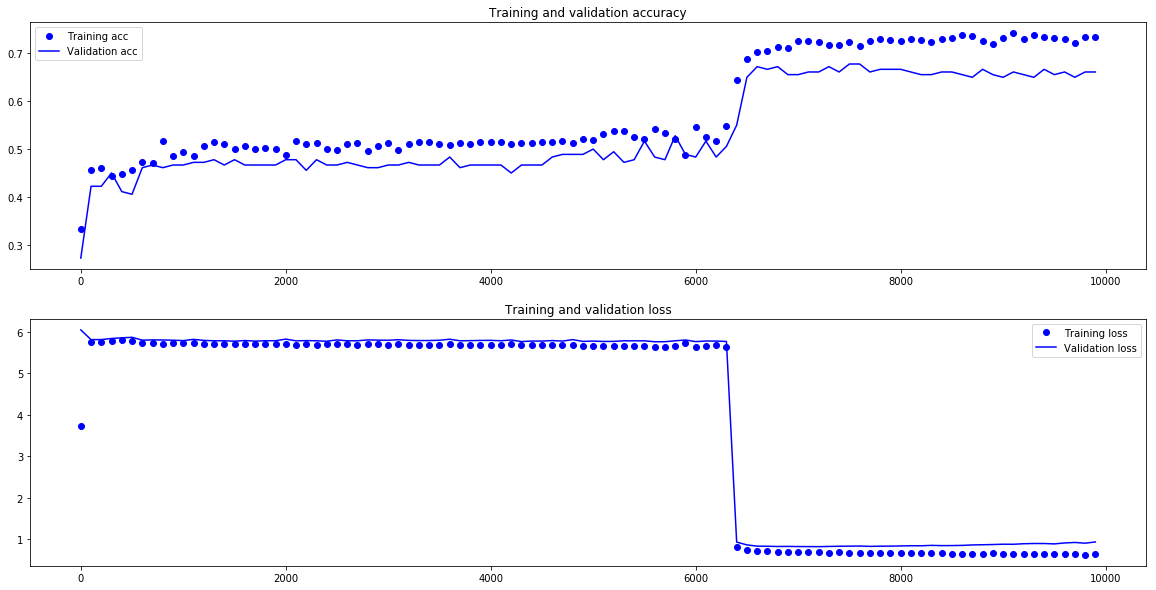

In [21]:
plot_history(history)

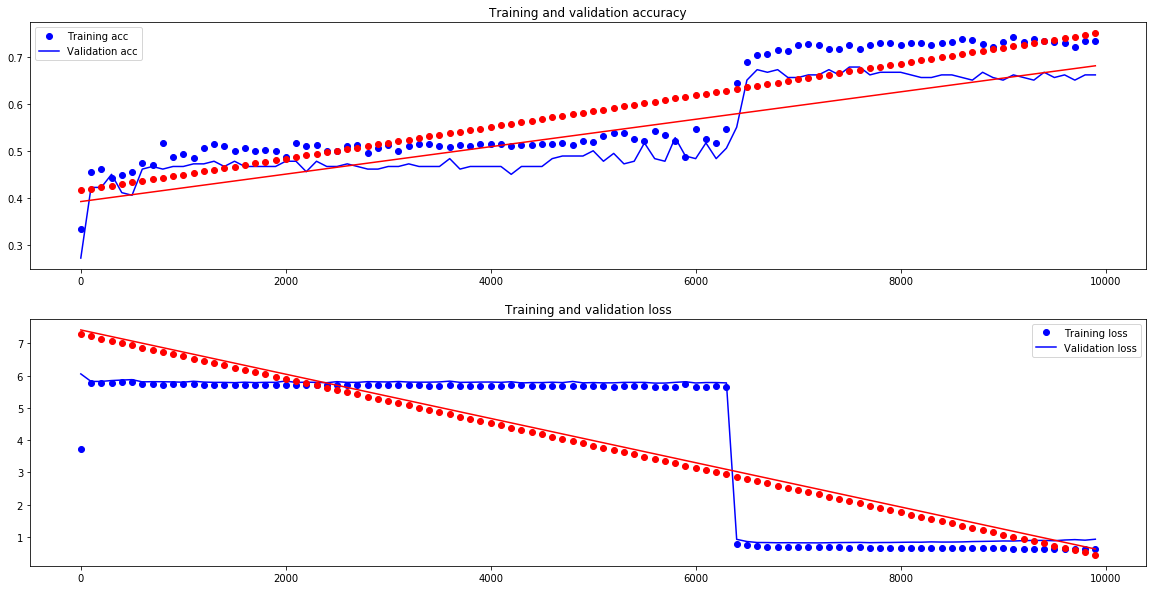

In [22]:
# sometimes it is not so easy if we still have a change, plot a line through the data
plot_history(history, plot_line=True)

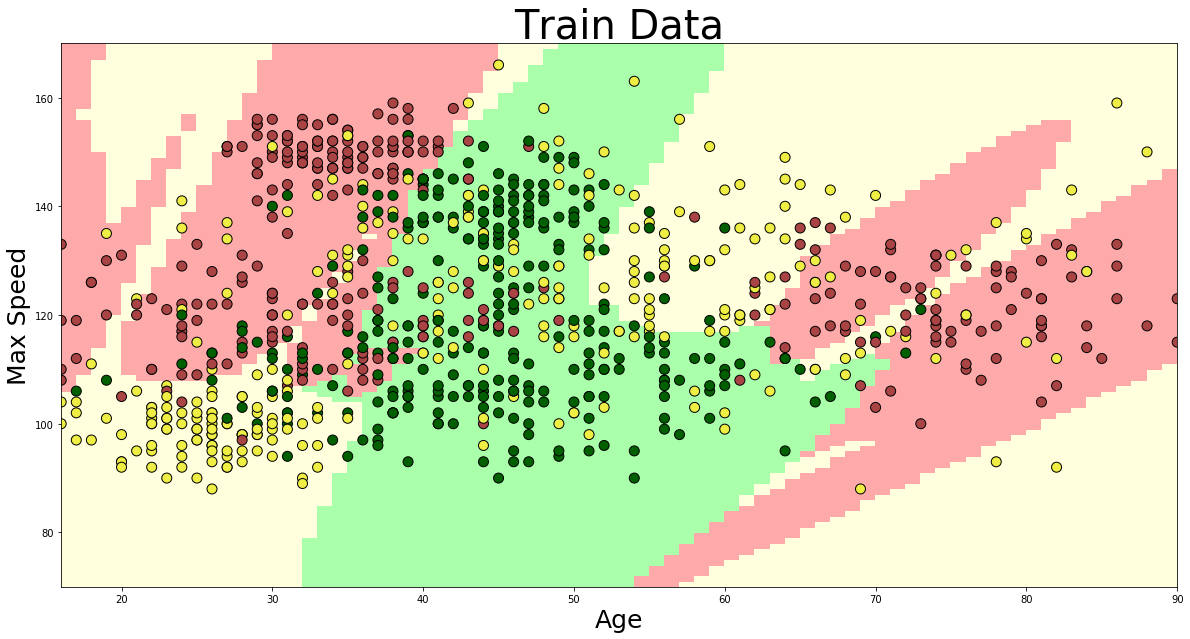

In [23]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

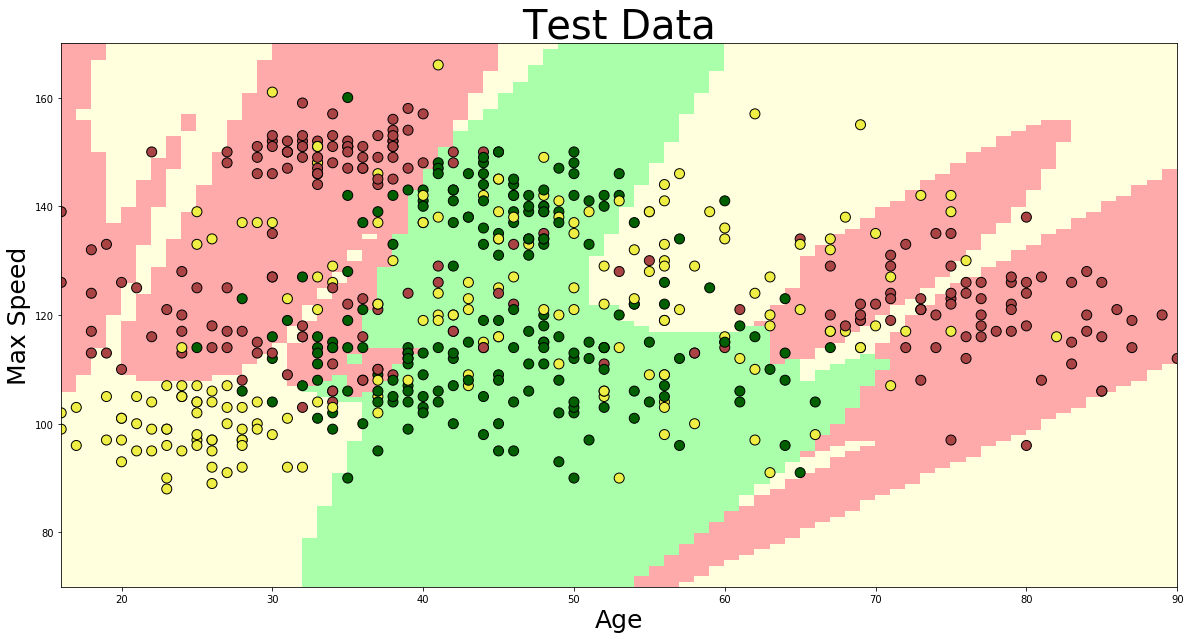

In [24]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

## When you have a decent model, save it for the next steps

In [25]:
model.save('insurance.hdf5')

In [26]:
!ls -l insurance.hdf5

-rw-r--r-- 1 olive 197609 3070424 Sep 13 08:46 insurance.hdf5
